# Análisis exploratorio de datos EDA
## Importar bibliotecas

In [1]:
#--- 
import pandas as pd
import numpy as np
#---
import re
from unidecode import unidecode
#---
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
#--- Scraping
import requests
from bs4 import BeautifulSoup

#---
import os
import requests
import gzip
import shutil
from tqdm import tqdm

import datetime
from datetime import timedelta, date
import math
import requests
from bs4 import BeautifulSoup
from pathlib import Path

## Scraping de Datos de la Web `data.buenosaires.gob.ar`

In [2]:


class DatasetDownloader:
    def __init__(self, base_url, download_folder):
        self.base_url = base_url
        self.download_folder = Path(download_folder)
        # Make sure the download directory exists
        self.download_folder.mkdir(parents=True, exist_ok=True)

    def scrape_siniestros_urls(self):
        response = requests.get(self.base_url)
        soup = BeautifulSoup(response.content, 'html.parser')
        links = soup.find_all('a')

        file_urls = {}
        for link in links:
            href = link.get('href')
            if href and href.endswith(('.zip', '.xlsx', '.csv', '.gz', '.geojson', '.pdf')):
                file_name = href.split('/')[-1]
                file_urls[file_name] = href
        return file_urls

    def download_file(self, url, save_path):
        try:
            response = requests.get(url, stream=True)
            response.raise_for_status()
            with open(save_path, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
            print(f"Archivo guardado: {save_path}")
        except Exception as e:
            print(f"Error al descargar el archivo: {url}")
            print(f"Error details: {e}")

    def download_datasets(self):
        file_urls_dict = self.scrape_siniestros_urls()
        for file_name, url in file_urls_dict.items():
            save_path = self.download_folder / file_name
            self.download_file(url, save_path)

# Example usage
base_url = 'https://data.buenosaires.gob.ar/dataset/victimas-siniestros-viales'

base_url2 = 'https://data.buenosaires.gob.ar/dataset/comunas'

download_folder = '../datasets/raw'
downloader = DatasetDownloader(base_url, download_folder)
downloader.download_datasets()
downloader = DatasetDownloader(base_url2, download_folder)
downloader.download_datasets()
base_url =  'https://data.buenosaires.gob.ar/dataset/informacion-censal-por-radio'
download_folder = '../datasets/raw'
downloader = DatasetDownloader(base_url, download_folder)
downloader.download_datasets()

Archivo guardado: ..\datasets\raw\lesiones.xlsx
Archivo guardado: ..\datasets\raw\homicidios.xlsx
Archivo guardado: ..\datasets\raw\NOTAS_LESIONES_SINIESTRO_VIAL.pdf
Archivo guardado: ..\datasets\raw\NOTAS_HOMICIDIOS_SINIESTRO_VIAL.pdf
Archivo guardado: ..\datasets\raw\comunas.csv
Archivo guardado: ..\datasets\raw\comunas.xlsx
Archivo guardado: ..\datasets\raw\comunas.zip
Archivo guardado: ..\datasets\raw\comunas.geojson
Archivo guardado: ..\datasets\raw\informacion-censal-por-radio-2010.csv
Archivo guardado: ..\datasets\raw\informacion-censal-por-radio-2010.xlsx
Archivo guardado: ..\datasets\raw\informacion-censal-por-radio-2010.zip
Archivo guardado: ..\datasets\raw\caba_radios_censales.geojson
Archivo guardado: ..\datasets\raw\informacion-censal-por-radio-2001.csv
Archivo guardado: ..\datasets\raw\informacion-censal-por-radio-2001.xlsx
Archivo guardado: ..\datasets\raw\informacion-censal-por-radio-2001.zip


## Importación de Datos Directorio `../datasets/raw` 

In [3]:
homicidios = pd.read_excel('../datasets/raw/homicidios.xlsx',sheet_name = 'HECHOS', engine='openpyxl')
victima_h = pd.read_excel('../datasets/raw/homicidios.xlsx',sheet_name = 'VICTIMAS',  engine='openpyxl')
comunas_h = pd.read_excel('../datasets/raw/comunas.xlsx' , sheet_name = 'comunas',  engine='openpyxl')
#lesiones = pd.read_excel('../datasets/raw/lesiones.xlsx' , sheet_name = 'HECHOS',  engine='openpyxl')
#victima_l = pd.read_excel('../datasets/raw/lesiones.xlsx' , sheet_name = 'VICTIMAS',  engine='openpyxl')
censo_r = pd.read_csv('../datasets/raw/informacion-censal-por-radio-2010.csv')
# Revsisón de Modelo de datos
homicidios.name = 'homicidios'
victima_h.name = 'victima_h'
comunas_h.name = 'comunas_h'
#lesiones.name = 'lesiones'
#victima_l.name = 'victima_l'
censo_r.name = 'censo_r'



In [4]:
pd.set_option('display.max_columns', None)
dataframes = [homicidios, victima_h, comunas_h, censo_r]

## Análisis exploratorio de datos EDA
#### Exploración de Moda, Mediana, Media de cada Tablas `homicidios`, `victima_h` ,`comunas_h`y `censo_r`.

In [4]:

# for df in dataframes:
#     print(f"Dataframe {df.name}:\nRegistros {df.shape[0]} y Columnas {df.shape[1]}\n\n{df.head(3)} \n\n\n")

In [4]:
def calculate_statistics(df):
    print(f"Estadísticas para el DataFrame {df.name}:\n")
    
    for column in df.columns:
        unique_values = df[column].unique()[:5]
        print(f"Columna: {column}, Valores únicos: {unique_values}")
        
        if pd.api.types.is_numeric_dtype(df[column]):
            print(f"Media: {df[column].mean()}")
            print(f"Mediana: {df[column].median()}")
        elif pd.api.types.is_object_dtype(df[column]):
            print(f"Moda: {df[column].mode().iloc[0]}")
        
        print("\n")

# Ejemplo de uso:

for df in dataframes:
    calculate_statistics(df)
    print("\n\n")

Estadísticas para el DataFrame homicidios:

Columna: ID, Valores únicos: ['2016-0001' '2016-0002' '2016-0003' '2016-0004' '2016-0005']
Moda: 2016-0001


Columna: N_VICTIMAS, Valores únicos: [1 2 3]
Media: 1.0301724137931034
Mediana: 1.0


Columna: FECHA, Valores únicos: <DatetimeArray>
['2016-01-01 00:00:00', '2016-01-02 00:00:00', '2016-01-03 00:00:00',
 '2016-01-10 00:00:00', '2016-01-21 00:00:00']
Length: 5, dtype: datetime64[ns]


Columna: AAAA, Valores únicos: [2016 2017 2018 2019 2020]
Media: 2018.1882183908046
Mediana: 2018.0


Columna: MM, Valores únicos: [1 2 3 4 5]
Media: 6.692528735632184
Mediana: 7.0


Columna: DD, Valores únicos: [ 1  2  3 10 21]
Media: 15.936781609195402
Mediana: 16.0


Columna: HORA, Valores únicos: [datetime.time(4, 0) datetime.time(1, 15) datetime.time(7, 0)
 datetime.time(0, 0) datetime.time(5, 20)]
Moda: 14:00:00


Columna: HH, Valores únicos: [4 1 7 0 5]
Moda: 7


Columna: LUGAR_DEL_HECHO, Valores únicos: ['AV PIEDRA BUENA Y AV FERNANDEZ DE LA CRUZ'

### Análisis de Valores de cada Tablas `homicidios`, `victima_h` ,`comunas_h`y `censo_r`.
- Si Dataframe no está en el listado de Valores Nulos, se asume información Completa 

In [5]:
#dataframes = [homicidios, victima_h, comunas_h, lesiones, victima_l]

# Crear un DataFrame para almacenar la información sobre valores raros
reg_valores_raros = pd.DataFrame(columns=['Nombre DataFrame', 'Nombre Columna', 'Tipo de Dato', 'Total Valores', 'Total Nulos', 'Total Raros', 'Valores Faltantes %'])

# Definir qué valores consideras "raros"
valores_raros = ['SD', 'No especificado', 'sd' , '', 'Point (. .)']

# Iterar sobre cada DataFrame
for df in dataframes:
    # Iterar sobre cada columna del DataFrame
    for columna in df.columns:
        # Obtener información de cada columna
        nombre_df = df.name
        nombre_columna = columna
        tipo_dato = df[columna].dtype
        total_valores = len(df)
        total_nulos = df[columna].isnull().sum()
        total_raros = df[columna].isin(valores_raros).sum()
        total_nulos_y_raros = total_nulos + total_raros
        porcentaje_raros = ((total_nulos + total_raros )/ total_valores) * 100

        # Agregar la información al DataFrame de resumen
        reg_valores_raros.loc[len(reg_valores_raros)] = [nombre_df, nombre_columna, tipo_dato, total_valores, total_nulos, total_raros,  porcentaje_raros]

# Filtrar el DataFrame para mostrar solo las filas con 'Total Raros' mayor que cero
reg_valores_raros_c = reg_valores_raros[reg_valores_raros['Valores Faltantes %'] > 0]


"""
# Contar los valores únicos y su frecuencia en la columna 'GRAVEDAD'
conteo_gravedad = victima_l['GRAVEDAD'].value_counts()
# Mostrar el resultado
print(conteo_gravedad)
"""
# Ordenar el DataFrame por 'Valores Faltantes %' de forma descendente
reg_valores_raros_c = reg_valores_raros_c.sort_values(by='Valores Faltantes %', ascending=False)

# Mostrar el DataFrame ordenado
reg_valores_raros_c.head(50)

,Nombre DataFrame,Nombre Columna,Tipo de Dato,Total Valores,Total Nulos,Total Raros,Valores Faltantes %
11,homicidios,Altura,float64,696,567,0,81.465517
12,homicidios,Cruce,object,696,171,0,24.568966
30,victima_h,FECHA_FALLECIMIENTO,object,717,0,68,9.483961
29,victima_h,EDAD,object,717,0,53,7.391911
20,homicidios,ACUSADO,object,696,0,23,3.304598
15,homicidios,XY (CABA),object,696,0,14,2.011494
26,victima_h,ROL,object,717,0,11,1.534170
19,homicidios,VICTIMA,object,696,0,9,1.293103
27,victima_h,VICTIMA,object,717,0,9,1.255230
13,homicidios,Dirección Normalizada,object,696,8,0,1.149425


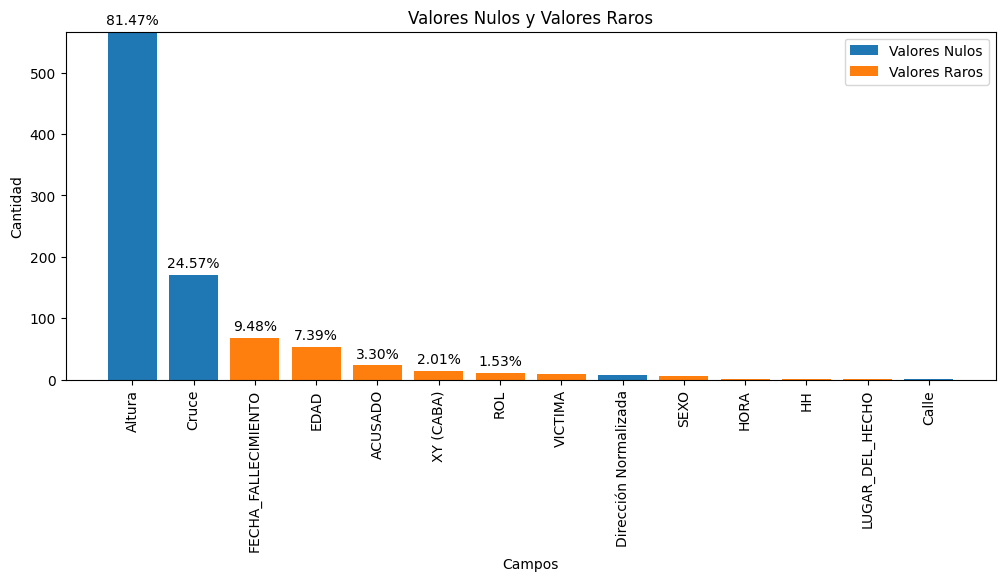

In [6]:
# Crear una figura y ejes
fig, ax = plt.subplots(figsize=(12, 6))

# Graficar barras apiladas para valores nulos y raros
barras = ax.bar(reg_valores_raros_c['Nombre Columna'], reg_valores_raros_c['Total Nulos'], label='Valores Nulos')
barras_raros = ax.bar(reg_valores_raros_c['Nombre Columna'], reg_valores_raros_c['Total Raros'], bottom=reg_valores_raros_c['Total Nulos'], label='Valores Raros')

# Configurar etiquetas y título
ax.set_xlabel('Campos')
ax.set_ylabel('Cantidad')
ax.set_title('Valores Nulos y Valores Raros')

# Rotar las etiquetas del eje x
plt.xticks(rotation=90)

# Agregar leyenda
ax.legend()

# Ajustar el espaciado entre subgráficos
plt.subplots_adjust(bottom=0.3)

# Obtener las 7 barras más altas
alturas_barras = [bar.get_height() for bar in barras]
alturas_barras_raros = [bar.get_height() for bar in barras_raros]
alturas_totales = [x + y for x, y in zip(alturas_barras, alturas_barras_raros)]
indices_mayores = sorted(range(len(alturas_totales)), key=lambda x: alturas_totales[x], reverse=True)[:7]

# Agregar etiquetas con porcentajes a las 7 barras más altas
for i, indice in enumerate(indices_mayores):
    altura_total = alturas_totales[indice]
    porcentaje = altura_total / reg_valores_raros_c['Total Valores'].iloc[indice] * 100
    ax.text(indice, altura_total + 0.01 * reg_valores_raros_c['Total Valores'].max(), f"{porcentaje:.2f}%", ha='center', va='bottom')

# Mostrar el gráfico
plt.show()

### PreProcesamiento de Columnas de las Tablas `homicidios`, `victima_h` ,`comunas_h`y `censo_r`.

In [5]:
# Función para limpiar y formatear los nombres de las columnas
def limpiar_nombre(nombre):
    # Eliminar caracteres especiales y espacios
    nombre = re.sub(r'\W+', '_', nombre)
    # Eliminar acentos
    nombre = unidecode(nombre)
    # Convertir a minúsculas
    nombre = nombre.lower()
    return nombre

def limpiar_nombres_columnas(df):
    df.columns = [limpiar_nombre(col) for col in df.columns]

# Aplicar la función limpiar_nombres_columnas a cada DataFrame
for df in dataframes:
    limpiar_nombres_columnas(df)

# Imprimir los nombres de las columnas limpias para cada DataFrame
for df in dataframes:
    print(f"Columnas de {df.name}:")
    print(df.columns)
    print()

Columnas de homicidios:
Index(['id', 'n_victimas', 'fecha', 'aaaa', 'mm', 'dd', 'hora', 'hh',
       'lugar_del_hecho', 'tipo_de_calle', 'calle', 'altura', 'cruce',
       'direccion_normalizada', 'comuna', 'xy_caba_', 'pos_x', 'pos_y',
       'participantes', 'victima', 'acusado'],
      dtype='object')

Columnas de victima_h:
Index(['id_hecho', 'fecha', 'aaaa', 'mm', 'dd', 'rol', 'victima', 'sexo',
       'edad', 'fecha_fallecimiento'],
      dtype='object')

Columnas de comunas_h:
Index(['id', 'objeto', 'comunas', 'barrios', 'perimetro', 'area'], dtype='object')

Columnas de censo_r:
Index(['wkt', 'id', 'co_frac_ra', 'comuna', 'fraccion', 'radio', 'total_pob',
       't_varon', 't_mujer', 't_vivienda', 'v_particul', 'v_colectiv',
       't_hogar', 'h_con_nbi', 'h_sin_nbi'],
      dtype='object')



### PreProcesamiento de Valores Faltantes de las Tablas `homicidios`, `victima_h` ,`comunas_h`y `censo_r`.
- Revisamos diferentes caracteres para representar los valores faltantes, lo cual se representa un indicador de normalización previa, sin embargo, para mejorar el dato se normalizara todos los valores faltantes a tipo nan para que en posteriores análisis se evalue y considere la porción de datos faltantes.

In [6]:
def reemplazar_nulos_y_raros(dataframes, valores_raros):
    dataframes_limpios = []

    for df in dataframes:
        # Reemplazar los valores raros con NaN
        df = df.replace(valores_raros, pd.NaT)

        # Reemplazar los valores nulos con NaN
        df = df.replace('', pd.NaT)

        dataframes_limpios.append(df)

    return dataframes_limpios

dataframes = [homicidios, victima_h, comunas_h, censo_r]
# Definir qué valores consideras "raros"
valores_raros = ['SD', 'No especificado', 'sd' , '']
# Ejemplo de uso
# Supongamos que tienes una lista de DataFrames llamada 'dataframes' y 'valores_raros' es la lista de valores raros
dataframes_limpios = reemplazar_nulos_y_raros(dataframes, valores_raros)

# Puedes asignar cada DataFrame tratado a una variable separada
homicidios_l, victima_h_l, comunas_h_l, censo_r_l = dataframes_limpios.copy()

### PreProcesamiento de Tabla `homicidos`

In [7]:
def procesar_dataframe(df):
    # Convertir la columna de fecha a datetime
    df['fecha'] = pd.to_datetime(df['fecha'])

    # Crear nuevas columnas para año, mes y día
    df['anio'] = df['fecha'].dt.year
    df['mes'] = df['fecha'].dt.month
    df['dia'] = df['fecha'].dt.day

    # Llenar los valores nulos en 'hora' con '00:00:00'
    df['hora'] = df['hora'].fillna('00:00:00')


    # Convertir 'hora' a formato datetime
    df['hora'] = pd.to_datetime(df['hora'], format='%H:%M:%S')

    # Crear una nueva columna para fecha y hora combinadas
    df['fecha_hora'] = pd.to_datetime(dict(
        year=df['anio'],
        month=df['mes'],
        day=df['dia'],
        hour=df['hora'].dt.hour,
        minute=df['hora'].dt.minute
    ))

    # Eliminar columnas innecesarias
    columns_to_drop = ['fecha', 'aaaa', 'mm', 'dd', 'hh','hora','altura']
    df = df.drop(columns=columns_to_drop)

    # Crear columnas formateadas para fecha y hora
    df['fecha_formato'] = df['fecha_hora'].dt.strftime('%Y-%m-%d')
    df['hora_formato'] = df['fecha_hora'].dt.strftime('%H:%M')
    df['hora_i'] = df['fecha_hora'].dt.strftime('%H')
    df['hora_i'] = df['hora_i'].astype('int')

    return df

# Ejemplo de uso:
# Supongamos que tu DataFrame se llama 'df'
homicidios_l = procesar_dataframe(homicidios_l.copy())


In [8]:
def procesar_homicidios_l(df):
    
    # Seleccionar todas las columnas de tipo objeto
    columnas_objeto = df.select_dtypes(include=['object']).columns
    
    # Reemplazar los valores NaN con "SRE" en las columnas seleccionadas
    df[columnas_objeto] = df[columnas_objeto].fillna("SNR")
    
    return df

# Ejemplo de uso:
# Supongamos que tu DataFrame se llama 'victima_h_l'
homicidios_l = procesar_homicidios_l(homicidios_l.copy())

In [9]:
def procesar_homicidios_l(df):
    valid_positions = ~(df['pos_x'].str.contains('[^0-9.,-]') | df['pos_y'].str.contains('[^0-9.,-]') | (df['pos_x'] == '.') | (df['pos_y'] == '.'))

    # Establecer posiciones no válidas en NaN
    df.loc[~valid_positions, ['pos_x', 'pos_y']] = np.nan

    # Convertir las cadenas a tipo numérico (float)
    df['pos_x'] = df['pos_x'].str.replace(',', '.').astype(float)
    df['pos_y'] = df['pos_y'].str.replace(',', '.').astype(float)
    # Supongamos que tu DataFrame se llama df
    df.rename(columns={'pos_x': 'longitud', 'pos_y': 'latitud'}, inplace=True)
    return df
def extraer_coordenadas(texto):
    # Utilizamos una expresión regular para extraer las coordenadas
    coordenadas = re.findall(r'\d+\.\d+', texto)
    if len(coordenadas) == 2:
        return float(coordenadas[0]), float(coordenadas[1])
    else:
        return None, None

homicidios_lm = procesar_homicidios_l(homicidios_l)
# Aplicar la función a la columna 'XY (CABA)'
homicidios_lm['coordenada_x'], homicidios_lm['coordenada_y'] = zip(*homicidios_lm['xy_caba_'].map(extraer_coordenadas))

# Eliminar columnas innecesarias
columns_to_drop = ['xy_caba_', 'calle','cruce','participantes', 'victima']
homicidios_lm = homicidios_lm.drop(columns=columns_to_drop)



In [10]:
homicidios_lm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 696 entries, 0 to 695
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     696 non-null    object        
 1   n_victimas             696 non-null    int64         
 2   lugar_del_hecho        696 non-null    object        
 3   tipo_de_calle          696 non-null    object        
 4   direccion_normalizada  696 non-null    object        
 5   comuna                 696 non-null    int64         
 6   longitud               684 non-null    float64       
 7   latitud                684 non-null    float64       
 8   acusado                696 non-null    object        
 9   anio                   696 non-null    int32         
 10  mes                    696 non-null    int32         
 11  dia                    696 non-null    int32         
 12  fecha_hora             696 non-null    datetime64[ns]
 13  fecha

### PreProcesamiento de Tabla `victima_l`

In [11]:
def procesar_victima_h_l(df):
    # Llenar los valores nulos en 'fecha_fallecimiento' con 'fecha' + 7 días
    df['fecha_fallecimiento'] = df['fecha_fallecimiento'].combine_first(df['fecha'] + pd.DateOffset(days=7))
    
    df['edad'] = pd.to_numeric(df['edad'], errors='coerce')
    
    # Llenar los valores nulos en 'edad' con -1
    df['edad'] = df['edad'].fillna(-1)
    
    # Filtrar valores no negativos en 'edad' y luego convertir a entero
    df['edad'] = np.where((df['edad'] >= 0), df['edad'].astype(int), -1)

  
    # Seleccionar todas las columnas de tipo objeto
    columnas_objeto = df.select_dtypes(include=['object']).columns
    
    # Reemplazar los valores NaN con "SRE" en las columnas seleccionadas
    df[columnas_objeto] = df[columnas_objeto].fillna("SNR")
    
    # Eliminar columnas innecesarias
    columns_to_drop = ['fecha', 'aaaa', 'mm', 'dd']
    df2 = df.drop(columns=columns_to_drop)
    
    # Llenar los valores nulos en 'hora' con '00:00:00'
    df2['fecha_fallecimiento'] = df2['fecha_fallecimiento'].fillna('2018-09-21 00:00:00')
    df2['fecha_fallecimiento'] = pd.to_datetime(df2['fecha_fallecimiento'])

    return df2

# Ejemplo de uso:
# Supongamos que tu DataFrame se llama 'victima_h_l'
victima_h_lm = procesar_victima_h_l(victima_h_l.copy())


In [12]:
victima_h_lm.head(5)

,id_hecho,rol,victima,sexo,edad,fecha_fallecimiento
0,2016-0001,CONDUCTOR,MOTO,MASCULINO,19,2016-01-01
1,2016-0002,CONDUCTOR,AUTO,MASCULINO,70,2016-01-02
2,2016-0003,CONDUCTOR,MOTO,MASCULINO,30,2016-01-03
3,2016-0004,CONDUCTOR,MOTO,MASCULINO,18,2016-01-17
4,2016-0005,CONDUCTOR,MOTO,MASCULINO,29,2016-02-01


In [13]:
victima_h_lm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id_hecho             717 non-null    object        
 1   rol                  717 non-null    object        
 2   victima              717 non-null    object        
 3   sexo                 717 non-null    object        
 4   edad                 717 non-null    int32         
 5   fecha_fallecimiento  717 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int32(1), object(4)
memory usage: 30.9+ KB


In [14]:
victima_h_lm.edad.unique()

array([19, 70, 30, 18, 29, 22, 16, 59, 65, 34, 41, 50, 38, 21, 52, 36, 20,
       54, -1, 56, 24, 78, 79, 26, 57, 37, 58, 23, 60, 42, 53, 51, 40, 87,
       76, 75, 35, 80, 43, 45, 67, 27, 55, 49, 81, 25, 33, 46, 83, 39, 28,
        7, 48,  4, 82, 32, 17, 47, 61, 10, 95, 73, 84, 66, 85,  1, 15, 13,
       77, 44, 31, 62, 74, 71, 11, 86, 69, 72, 12, 63, 92, 68, 91, 64,  5,
       88])

### Estadística Descriptiva  `homicidios`, `victima_h` ,`comunas_h`y `censo_r`.
- Revisamos diferentes valores para representar los estadístcos clave para cada modelo de datos de forma inicial previa
al modelo de ETL

In [15]:
dataNumericas = homicidios_lm.select_dtypes(include=['number']) 
dataNumericas.describe()

,n_victimas,comuna,longitud,latitud,anio,mes,dia,hora_i,coordenada_x,coordenada_y
count,696.000000,696.000000,684.000000,684.000000,696.000000,696.000000,696.000000,696.000000,682.000000,682.000000
mean,1.030172,7.425287,-58.441545,-34.619632,2018.188218,6.692529,15.935345,11.640805,101990.962338,101078.485362
std,0.179393,4.387050,0.046144,0.035289,1.683754,3.571309,8.641883,6.709834,4230.329590,3914.622909
min,1.000000,0.000000,-58.529942,-34.705250,2016.000000,1.000000,1.000000,0.000000,93889.867899,91571.233073
25%,1.000000,4.000000,-58.476218,-34.643689,2017.000000,4.000000,9.000000,6.000000,98807.750321,98407.889777
50%,1.000000,8.000000,-58.444513,-34.622928,2018.000000,7.000000,16.000000,11.000000,101721.590022,100708.189095
75%,1.000000,11.000000,-58.401841,-34.596799,2020.000000,10.000000,23.000000,17.250000,105630.884244,103634.991834
max,3.000000,15.000000,-58.356082,-34.534654,2021.000000,12.000000,31.000000,23.000000,109831.098614,110496.053085


In [16]:
dataNumericas2 = victima_h_lm.select_dtypes(include=['number']) 
dataNumericas2.describe()

,edad
count,717.000000
mean,38.976290
std,22.143154
min,-1.000000
25%,24.000000
50%,35.000000
75%,55.000000
max,95.000000


In [17]:
dataNumericas3 = comunas_h_l.select_dtypes(include=['number']) 
dataNumericas3.describe()

,id,comunas,perimetro,area
count,15.000000,15.000000,15.000000,1.500000e+01
mean,8.000000,8.000000,20587.190459,1.360458e+07
std,4.472136,4.472136,7510.793844,5.193868e+06
min,1.000000,1.000000,10486.260809,6.317265e+06
25%,4.500000,4.500000,17532.387476,9.636965e+06
50%,8.000000,8.000000,19987.696155,1.432290e+07
75%,11.500000,11.500000,21789.685253,1.617559e+07
max,15.000000,15.000000,36102.201573,2.221690e+07


In [18]:
dataNumericas4 = censo_r_l.select_dtypes(include=['number']) 
dataNumericas4.describe()

,id,comuna,fraccion,radio,total_pob,t_varon,t_mujer,t_vivienda,v_particul,v_colectiv,t_hogar,h_con_nbi,h_sin_nbi
count,3554.000000,3554.000000,3554.000000,3554.000000,3554.000000,3554.000000,3554.000000,3554.000000,3554.000000,3554.000000,3554.000000,3554.000000,3554.000000
mean,1777.500000,8.007597,12.375633,5.838773,813.210748,374.136466,439.074282,401.361283,400.835959,0.525324,323.616770,19.351716,304.265053
std,1026.095756,4.540923,7.364758,3.349121,292.823849,143.546304,154.216231,142.250885,142.176408,1.089858,105.766922,32.329852,103.503040
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,889.250000,4.000000,6.000000,3.000000,646.250000,294.000000,350.250000,311.250000,311.000000,0.000000,259.000000,2.000000,242.000000
50%,1777.500000,8.000000,12.000000,6.000000,786.000000,360.000000,425.000000,377.000000,377.000000,0.000000,310.000000,6.000000,295.000000
75%,2665.750000,12.000000,18.000000,8.000000,928.000000,428.000000,504.000000,462.000000,461.000000,1.000000,371.000000,23.000000,352.000000
max,3554.000000,15.000000,31.000000,23.000000,3945.000000,2012.000000,1933.000000,1405.000000,1405.000000,14.000000,1093.000000,403.000000,1052.000000


### Análisis de Outliers en  `homicidios`, `victima_h` ,`comunas_h`y `censo_r`.
- Revisamos diferentes caracteres para representar los valores faltantes, lo cual se representa un indicador de normalización previa, sin embargo, para mejorar el dato se normalizara todos los valores faltantes a tipo nan para que en posteriores análisis se evalue y considere la porción de datos faltantes.

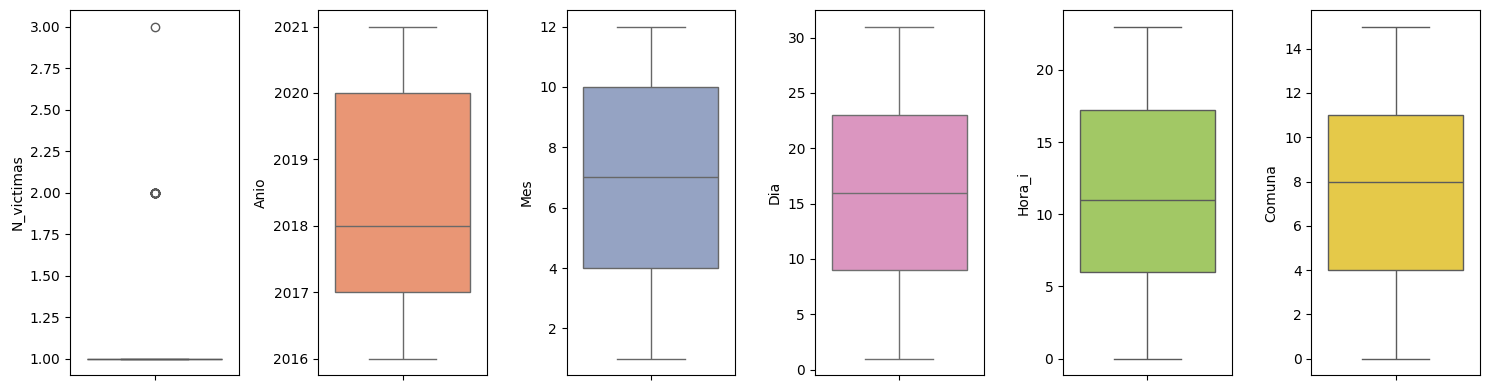

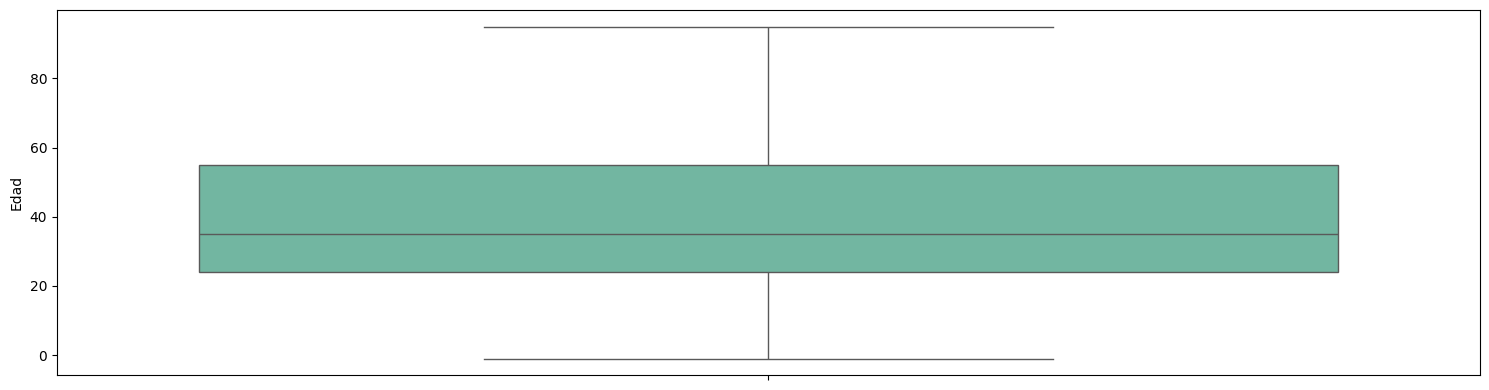

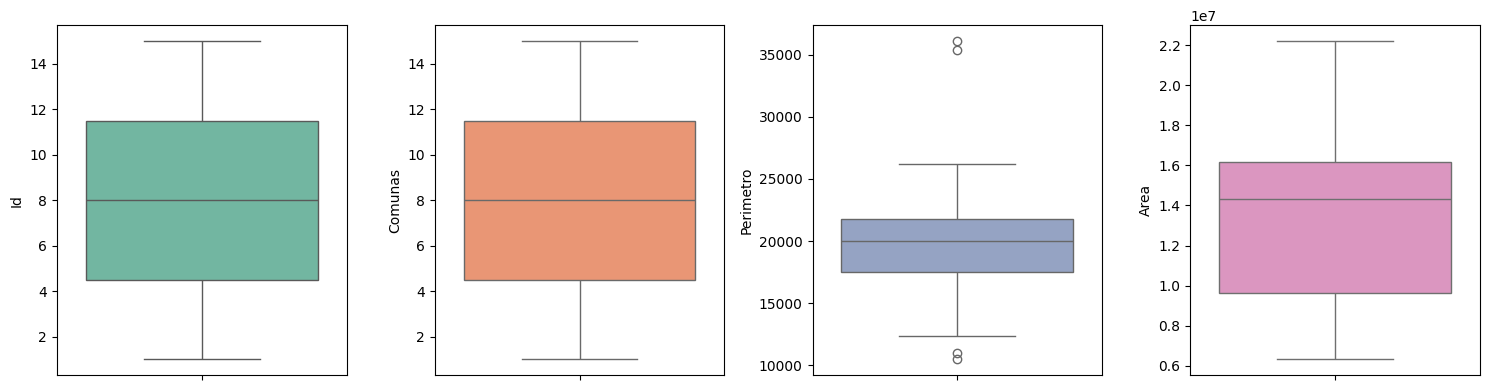

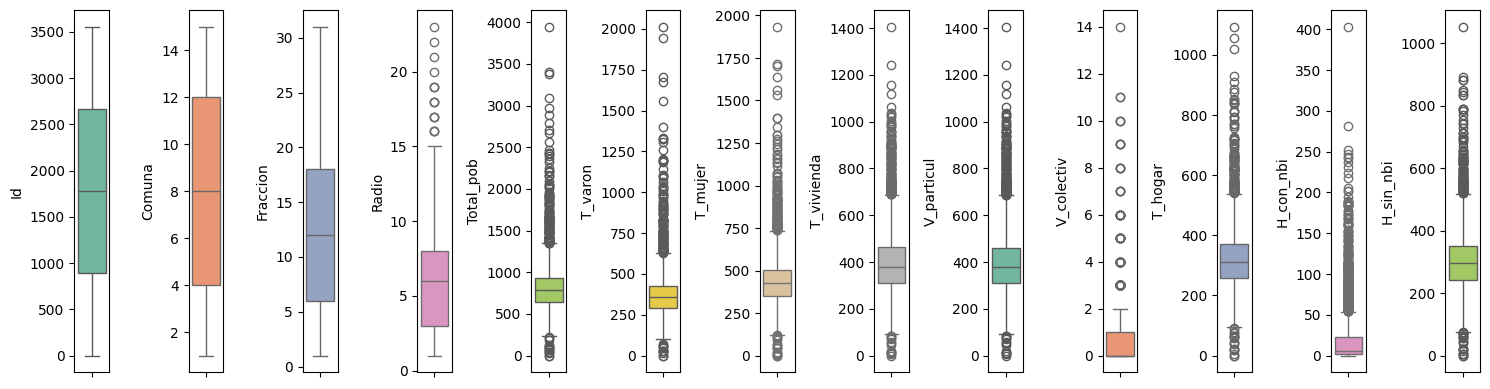

In [19]:
def plot_boxplots(df, numeric_vars, figsize=(15, 4)):
    # Ajustar el tamaño de la figura
    plt.figure(figsize=figsize)

    # Colores para los boxplots
    colors = sns.color_palette("Set2", n_colors=len(numeric_vars))

    # Crear subplots para los gráficos
    for i, variable in enumerate(numeric_vars, start=1):
        plt.subplot(1, len(numeric_vars), i)
        sns.boxplot(data=df, y=variable, color=colors[i-1])
        plt.ylabel(variable.capitalize())  # Añadir etiquetas en mayúsculas para mejor legibilidad

    # Ajustar espaciado entre subplots
    plt.tight_layout()

    # Mostrar el gráfico
    plt.show()

# Ejemplo de uso con homicidios_lm
numeric_variables_homicidios = ['n_victimas', 'anio', 'mes', 'dia', 'hora_i', 'comuna']
plot_boxplots(homicidios_lm, numeric_variables_homicidios)

plot_boxplots(victima_h_lm, victima_h_lm.select_dtypes(include=['number']).columns)
plot_boxplots(comunas_h_l, comunas_h_l.select_dtypes(include=['number']).columns)
plot_boxplots(censo_r_l, censo_r_l.select_dtypes(include=['number']).columns)

##### 1. **Siniestros Fatales (homicidios_l):**
- **n_victimas:**
  - En promedio, hay alrededor de 1 víctima por homicidio.
  - La desviación estándar indica que la mayoría de los homicidios tienen una víctima, pero hay cierta variabilidad.
- **anio:**
  - Los homicidios se distribuyen entre los años 2016 y 2021.
  - El promedio sugiere una concentración de homicidios en los años más recientes.
- **mes, dia, hora_i:**
  - Los homicidios se distribuyen en todos los meses, días del mes y horas del día.
  - La variabilidad en los estadísticos indica una distribución equitativa a lo largo del tiempo.

##### 2. **Víctimas de Siniestros Fatales (victima_h_l):**
- **aaaa (año), mm (mes), dd (día):**
  - Los datos abarcan desde el año 2016 hasta el 2021.
  - La distribución de meses y días sugiere que hay información para cada mes y día del mes en los años analizados.

##### 3. **Comunas (comunas_h_l):**
- **id, comunas, perimetro, area:**
  - Hay 15 comunas en el conjunto de datos.
  - El perímetro y el área varían, lo que indica diferencias significativas en la geometría de las comunas.
- **mean (promedio):**
  - La media de las comunas está alrededor de 8, sugiriendo que la mayoría de las comunas están centradas en ese valor.

##### 4. **Censo Residencial (censo_r_l):**
- **total_pob, t_varon, t_mujer, t_vivienda, v_particul, v_colectiv, t_hogar, h_con_nbi, h_sin_nbi:**
  - Se observa una variabilidad en la población total, la vivienda, y otros indicadores demográficos.
- **mean (promedio):**
  - La media de las variables indica el valor promedio para cada comuna.
- **std (desviación estándar):**
  - La desviación estándar proporciona una medida de la dispersión de los datos.
- **min, 25%, 50%, 75%, max:**
  - Proporcionan una visión de la distribución y variabilidad de los datos en diferentes percentiles.

##### Conclusiones Generales:
- Los homicidios se distribuyen de manera relativamente uniforme a lo largo del tiempo, mostrando variabilidad en el número de víctimas.
- Los datos de víctimas y comunas proporcionan una cobertura completa a lo largo de los años y una diversidad geográfica.
- El censo residencial refleja una variabilidad en la población y características demográficas de las comunas.

### Balanceo en Clases de `homicidios`, `victima_h` ,`comunas_h`y `censo_r`.


In [22]:
import plotly.express as px

def barplot_visualization(df, column):
    """
    Crea un gráfico de barras interactivo para visualizar la frecuencia de valores en una columna de un DataFrame.

    Parameters:
    - df (pd.DataFrame): El DataFrame que contiene los datos.
    - column (str): El nombre de la columna que se desea visualizar.

    Returns:
    None
    """
    # Crear DataFrame con value_counts() y reset_index()
    value_counts_df = df[column].value_counts().reset_index()
    # Cambiar el nombre de las columnas para que coincidan con las necesarias para el gráfico
    value_counts_df.columns = ['values', 'count']

    # Utilizar Plotly Express para crear el gráfico de barras
    fig = px.bar(value_counts_df, x='values', y='count', color='values',
                 labels={column: 'Frecuencia', 'values': column},
                 title=f'Frecuencia de valores en la columna "{column}"',
                 template='plotly_dark')
    
    fig.show()

# Ejemplo de uso:
barplot_visualization(homicidios_lm, 'n_victimas')
barplot_visualization(homicidios_lm, 'tipo_de_calle')
barplot_visualization(homicidios_lm, 'comuna')
barplot_visualization(homicidios_lm, 'acusado')
barplot_visualization(homicidios_lm, 'anio')
barplot_visualization(homicidios_lm, 'mes')
barplot_visualization(homicidios_lm, 'dia')
barplot_visualization(homicidios_lm, 'hora_i')


In [23]:
barplot_visualization(victima_h_lm, 'rol')
barplot_visualization(victima_h_lm, 'victima')
barplot_visualization(victima_h_lm, 'sexo')
barplot_visualization(victima_h_lm, 'edad')

In [24]:
barplot_visualization(comunas_h_l, 'barrios')

In [43]:
barplot_visualization(censo_r_l, 'total_pob')
barplot_visualization(censo_r_l, 't_varon')
barplot_visualization(censo_r_l, 't_mujer')
barplot_visualization(censo_r_l, 't_vivienda')
barplot_visualization(censo_r_l, 'v_particul')
barplot_visualization(censo_r_l, 'v_colectiv')
barplot_visualization(censo_r_l, 't_hogar')
barplot_visualization(censo_r_l, 'h_con_nbi')
barplot_visualization(censo_r_l, 'h_sin_nbi')

### Estrátegia para Modelado de  `homicidios`, `victima_h` ,`comunas_h`y `censo_r`.

In [46]:
victima_h_lm.columns 

Index(['id_hecho', 'rol', 'victima', 'sexo', 'edad', 'fecha_fallecimiento'], dtype='object')

In [30]:
homicidios_lm.columns

Index(['id', 'n_victimas', 'lugar_del_hecho', 'tipo_de_calle',
       'direccion_normalizada', 'comuna', 'longitud', 'latitud', 'acusado',
       'anio', 'mes', 'dia', 'fecha_hora', 'fecha_formato', 'hora_formato',
       'hora_i', 'coordenada_x', 'coordenada_y'],
      dtype='object')

In [31]:
homicidios_lm.comuna.value_counts()

comuna
1     90
4     76
9     73
8     65
7     60
3     45
15    44
13    40
12    37
14    35
11    32
10    29
2     25
5     22
6     21
0      2
Name: count, dtype: int64

In [32]:
comunas_h_l.columns

Index(['id', 'objeto', 'comunas', 'barrios', 'perimetro', 'area'], dtype='object')

In [36]:
comunas_h_l.head()

,id,objeto,comunas,barrios,perimetro,area
0,1,LIMITE COMUNAL,2,RECOLETA,21452.838648,6.317265e+06
1,2,LIMITE COMUNAL,5,ALMAGRO - BOEDO,12323.432479,6.660603e+06
2,3,LIMITE COMUNAL,6,CABALLITO,10990.964471,6.851029e+06
3,4,LIMITE COMUNAL,7,FLORES - PARQUE CHACABUCO,17972.257870,1.242290e+07
4,5,LIMITE COMUNAL,9,LINIERS - MATADEROS - PARQUE AVELLANEDA,21411.738344,1.650531e+07


In [35]:
comunas_h_l.comunas.value_counts()

comunas
2     1
5     1
6     1
7     1
9     1
10    1
11    1
12    1
14    1
3     1
15    1
8     1
4     1
1     1
13    1
Name: count, dtype: int64

In [37]:
censo_r_l.columns

Index(['wkt', 'id', 'co_frac_ra', 'comuna', 'fraccion', 'radio', 'total_pob',
       't_varon', 't_mujer', 't_vivienda', 'v_particul', 'v_colectiv',
       't_hogar', 'h_con_nbi', 'h_sin_nbi'],
      dtype='object')

In [38]:
censo_r_l.comuna.value_counts()

comuna
1     330
13    306
14    294
3     254
4     252
7     250
15    238
11    229
12    226
5     218
6     215
10    197
2     197
9     186
8     162
Name: count, dtype: int64

In [19]:
# Supongamos que tu DataFrame se llama homicidios_df
columnas_deseadas = ['id', 'n_victimas', 'tipo_de_calle', 'comuna', 'longitud', 'latitud', 'acusado',
                     'anio', 'mes', 'dia', 'hora_i']
# Puedes cambiar 'inner' por 'left', 'right', o 'outer' según tus necesidades específicas.

homicidios_lm = homicidios_lm[columnas_deseadas]
print(homicidios_lm.columns,  homicidios_lm.shape) # homicidios_lm 'id'  homicidios_lm 'comuna'
print(victima_h_lm.columns ,  victima_h_lm.shape) # victima_h_lm 'id_hecho'
columnas_deseadas = ['comunas', 'barrios', 'perimetro', 'area']
comunas_h_l= comunas_h_l[columnas_deseadas]
print(comunas_h_l.columns ,  comunas_h_l.shape)# comunas_h_l 'comunas'

columnas_deseadas = ['wkt', 'id', 'comuna',  'total_pob','t_varon', 't_mujer']
# Puedes cambiar 'inner' por 'left', 'right', o 'outer' según tus necesidades específicas.

censo_r_l= censo_r_l[columnas_deseadas]
censo_r_lm= censo_r_l.groupby('comuna').agg({'total_pob': 'sum', 't_varon': 'sum', 't_mujer': 'sum'}).reset_index()
print(homicidios_lm.columns,  homicidios_lm.shape) # homicidios_lm 'id' se relaciona con  victima_h_lm 'id_hecho'
#homicidios_lm 'comuna' se relaciona con comunas_h_l 'comunas' 
print(victima_h_lm.columns ,  victima_h_lm.shape) # victima_h_lm 'id_hecho'
print(comunas_h_l.columns ,  comunas_h_l.shape)# comunas_h_l 'comunas' se relaciona censo_r_l 'comuna'
print(censo_r_lm.columns ,  censo_r_lm.shape)# censo_r_l 'comuna'

Index(['id', 'n_victimas', 'tipo_de_calle', 'comuna', 'longitud', 'latitud',
       'acusado', 'anio', 'mes', 'dia', 'hora_i'],
      dtype='object') (696, 11)
Index(['id_hecho', 'rol', 'victima', 'sexo', 'edad', 'fecha_fallecimiento'], dtype='object') (717, 6)
Index(['comunas', 'barrios', 'perimetro', 'area'], dtype='object') (15, 4)
Index(['id', 'n_victimas', 'tipo_de_calle', 'comuna', 'longitud', 'latitud',
       'acusado', 'anio', 'mes', 'dia', 'hora_i'],
      dtype='object') (696, 11)
Index(['id_hecho', 'rol', 'victima', 'sexo', 'edad', 'fecha_fallecimiento'], dtype='object') (717, 6)
Index(['comunas', 'barrios', 'perimetro', 'area'], dtype='object') (15, 4)
Index(['comuna', 'total_pob', 't_varon', 't_mujer'], dtype='object') (15, 4)


In [20]:


# Supongamos que tienes los DataFrames homicidios_lm, victima_h_lm, comunas_h_l, y censo_r_l
# Paso 1: Relacionar homicidios_lm y victima_h_lm
merged_df = pd.merge(homicidios_lm, victima_h_lm, left_on='id', right_on='id_hecho', how='inner')

# Paso 2: Relacionar merged_df y comunas_h_l
merged_df = pd.merge(merged_df, comunas_h_l, left_on='comuna', right_on='comunas', how='inner')

# Paso 3: Relacionar comunas_h_l y censo_r_l
merged_df = pd.merge(merged_df, censo_r_lm, left_on='comunas', right_on='comuna', how='inner')

In [21]:
merged_df.head(5)

,id,n_victimas,tipo_de_calle,comuna_x,longitud,latitud,acusado,anio,mes,dia,hora_i,id_hecho,rol,victima,sexo,edad,fecha_fallecimiento,comunas,barrios,perimetro,area,comuna_y,total_pob,t_varon,t_mujer
0,2016-0001,1,AVENIDA,8,-58.475340,-34.687570,AUTO,2016,1,1,4,2016-0001,CONDUCTOR,MOTO,MASCULINO,19,2016-01-01,8,VILLA LUGANO - VILLA RIACHUELO - VILLA SOLDATI,20935.012513,2.221690e+07,8,187237,89545,97692
1,2016-0002,1,GRAL PAZ,9,-58.508775,-34.669777,PASAJEROS,2016,1,2,1,2016-0002,CONDUCTOR,AUTO,MASCULINO,70,2016-01-02,9,LINIERS - MATADEROS - PARQUE AVELLANEDA,21411.738344,1.650531e+07,9,161797,76207,85590
2,2016-0003,1,AVENIDA,1,-58.390403,-34.631894,AUTO,2016,1,3,7,2016-0003,CONDUCTOR,MOTO,MASCULINO,30,2016-01-03,1,CONSTITUCION - MONTSERRAT - PUERTO MADERO - RE...,36102.201573,1.779457e+07,1,205991,98160,107831
3,2016-0004,1,AVENIDA,8,-58.465039,-34.680930,SNR,2016,1,10,0,2016-0004,CONDUCTOR,MOTO,MASCULINO,18,2016-01-17,8,VILLA LUGANO - VILLA RIACHUELO - VILLA SOLDATI,20935.012513,2.221690e+07,8,187237,89545,97692
4,2016-0005,1,AVENIDA,1,-58.387183,-34.622466,PASAJEROS,2016,1,21,5,2016-0005,CONDUCTOR,MOTO,MASCULINO,29,2016-02-01,1,CONSTITUCION - MONTSERRAT - PUERTO MADERO - RE...,36102.201573,1.779457e+07,1,205991,98160,107831


In [22]:
merged_df.n_victimas.value_counts().sum()

715

In [23]:
merged_df.drop(['id_hecho','comunas', 'comuna_y', 'fecha_fallecimiento'], axis=1, inplace=True)
merged_df.shape

(715, 21)

## Análisis de Modelo  `Siniestros Fatales`.

In [24]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 715 entries, 0 to 714
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             715 non-null    object 
 1   n_victimas     715 non-null    int64  
 2   tipo_de_calle  715 non-null    object 
 3   comuna_x       715 non-null    int64  
 4   longitud       704 non-null    float64
 5   latitud        704 non-null    float64
 6   acusado        715 non-null    object 
 7   anio           715 non-null    int32  
 8   mes            715 non-null    int32  
 9   dia            715 non-null    int32  
 10  hora_i         715 non-null    int32  
 11  rol            715 non-null    object 
 12  victima        715 non-null    object 
 13  sexo           715 non-null    object 
 14  edad           715 non-null    int32  
 15  barrios        715 non-null    object 
 16  perimetro      715 non-null    float64
 17  area           715 non-null    float64
 18  total_pob 

### Estadística Descriptiva  en `Siniestros Fatales`.

In [25]:
merged_df.describe()

,n_victimas,comuna_x,longitud,latitud,anio,mes,dia,hora_i,edad,perimetro,area,total_pob,t_varon,t_mujer
count,715.000000,715.000000,704.000000,704.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,7.150000e+02,715.000000,715.000000,715.000000
mean,1.061538,7.451748,-58.441664,-34.619700,2018.180420,6.675524,15.934266,11.542657,39.088112,22882.611994,1.522497e+07,195830.172028,90925.372028,104904.800000
std,0.257363,4.373508,0.046397,0.035292,1.671028,3.570954,8.678986,6.697281,22.072691,8115.367993,4.855595e+06,22256.940783,10545.044500,12178.002061
min,1.000000,1.000000,-58.529942,-34.705250,2016.000000,1.000000,1.000000,0.000000,-1.000000,10486.260809,6.317265e+06,157827.000000,67979.000000,85590.000000
25%,1.000000,4.000000,-58.476556,-34.643918,2017.000000,4.000000,9.000000,6.000000,24.000000,17972.257870,1.265656e+07,182574.000000,84485.000000,97692.000000
50%,1.000000,8.000000,-58.444513,-34.622866,2018.000000,7.000000,16.000000,11.000000,35.000000,20935.012513,1.557093e+07,189832.000000,89545.000000,101936.000000
75%,1.000000,11.000000,-58.401841,-34.597013,2019.000000,10.000000,23.000000,17.000000,55.000000,26198.826953,1.779457e+07,218245.000000,102481.000000,115079.000000
max,3.000000,15.000000,-58.356082,-34.534654,2021.000000,12.000000,31.000000,23.000000,95.000000,36102.201573,2.221690e+07,231331.000000,103832.000000,127499.000000


In [26]:

merged_df.select_dtypes(include=['object']).columns
merged_df.tipo_de_calle.value_counts()

tipo_de_calle
AVENIDA      442
CALLE        137
GRAL PAZ      69
AUTOPISTA     67
Name: count, dtype: int64

In [27]:

# Supongamos que merged_df es tu DataFrame
object_columns = merged_df.select_dtypes(include=['object']).columns

# Diccionarios para almacenar los valores únicos y la moda de cada columna
unique_values_dict = {}
mode_values_dict = {}

# Iterar sobre las columnas de tipo objeto
for col in object_columns:
    unique_values_dict[col] = merged_df[col].unique()
    mode_values_dict[col] = merged_df[col].mode()

# Imprimir los resultados
for col, unique_values in unique_values_dict.items():
    print(f"Valores únicos en {col}: {unique_values[:5]}")

for col, mode_values in mode_values_dict.items():
    print(f"Moda en {col}: {mode_values}")

Valores únicos en id: ['2016-0001' '2016-0002' '2016-0003' '2016-0004' '2016-0005']
Valores únicos en tipo_de_calle: ['AVENIDA' 'GRAL PAZ' 'CALLE' 'AUTOPISTA']
Valores únicos en acusado: ['AUTO' 'PASAJEROS' 'SNR' 'OBJETO FIJO' 'CARGAS']
Valores únicos en rol: ['CONDUCTOR' 'PASAJERO_ACOMPAÑANTE' 'PEATON' 'SNR' 'CICLISTA']
Valores únicos en victima: ['MOTO' 'AUTO' 'PEATON' 'SNR' 'CARGAS']
Valores únicos en sexo: ['MASCULINO' 'FEMENINO' 'SNR']
Valores únicos en barrios: ['VILLA LUGANO - VILLA RIACHUELO - VILLA SOLDATI'
 'LINIERS - MATADEROS - PARQUE AVELLANEDA'
 'CONSTITUCION - MONTSERRAT - PUERTO MADERO - RETIRO - SAN NICOLAS - SAN TELMO'
 'VILLA DEL PARQUE - VILLA  DEVOTO - VILLA GRAL. MITRE - VILLA SANTA RITA'
 'AGRONOMIA - CHACARITA -  PARQUE CHAS -  PATERNAL - VILLA CRESPO - VILLA ORTUZAR']
Moda en id: 0    2017-0035
Name: id, dtype: object
Moda en tipo_de_calle: 0    AVENIDA
Name: tipo_de_calle, dtype: object
Moda en acusado: 0    AUTO
Name: acusado, dtype: object
Moda en rol: 0    

## Preprocesamiento en el Modelo de `Siniestros Fatales`.

In [28]:
def limpiar_columnas_objeto(df):
    # Iterar sobre las columnas de tipo objeto
    for col in df.select_dtypes(include=['object']).columns:
        # Tratar los valores únicos
        df[col] = (
            df[col]
            .str.lower()
            .str.replace(' ', '')
            .str.replace('-', '_')
            .str.replace('___', '_')
            .str.replace('ã‘', 'n')
            .str.replace('.', '')
        )
        
    return df


# Supongamos que df es tu DataFrame
sinestrosdb = limpiar_columnas_objeto(merged_df.copy())

In [29]:
# Imprimir los valores únicos y la moda después del tratamiento

for col in sinestrosdb.select_dtypes(include=['object']).columns:
    unique_values = sinestrosdb[col].unique()
    mode_values = sinestrosdb[col].mode()
    
    print(f"Valores únicos en {col}: {unique_values[:5]}")
    print(f"Moda en {col}: {mode_values}")
    print("\n")

# columns_to_check = ['tipo_de_calle', 'acusado', 'rol', 'victima', 'sexo', 'barrios']

# for col in columns_to_check:
#     unique_values = sinestrosdb[col].unique()
#     mode_values = sinestrosdb[col].mode()
    
#     print(f"Columna: {col}")
#     print(f"Valores únicos: {unique_values[:5]}")
#     print(f"Moda: {mode_values}")
#     print("\n")

Valores únicos en id: ['2016_0001' '2016_0002' '2016_0003' '2016_0004' '2016_0005']
Moda en id: 0    2017_0035
Name: id, dtype: object


Valores únicos en tipo_de_calle: ['avenida' 'gralpaz' 'calle' 'autopista']
Moda en tipo_de_calle: 0    avenida
Name: tipo_de_calle, dtype: object


Valores únicos en acusado: ['auto' 'pasajeros' 'snr' 'objetofijo' 'cargas']
Moda en acusado: 0    auto
Name: acusado, dtype: object


Valores únicos en rol: ['conductor' 'pasajero_acompañante' 'peaton' 'snr' 'ciclista']
Moda en rol: 0    conductor
Name: rol, dtype: object


Valores únicos en victima: ['moto' 'auto' 'peaton' 'snr' 'cargas']
Moda en victima: 0    moto
Name: victima, dtype: object


Valores únicos en sexo: ['masculino' 'femenino' 'snr']
Moda en sexo: 0    masculino
Name: sexo, dtype: object


Valores únicos en barrios: ['villalugano_villariachuelo_villasoldati'
 'liniers_mataderos_parqueavellaneda'
 'constitucion_montserrat_puertomadero_retiro_sannicolas_santelmo'
 'villadelparque_villadevoto

## Normalización de Variables para el Modelo `Siniestros Fatales`.

In [30]:
# Seleccionar solo las columnas categóricas
categorical_columns = ['tipo_de_calle', 'acusado', 'rol', 'victima', 'sexo', 'barrios']
categorical_df = sinestrosdb[categorical_columns]

# Convertir las columnas categóricas a tipo str (si no lo están ya)
categorical_df = categorical_df.astype(str)

# Aplicar one-hot encoding
onehot_df = pd.get_dummies(categorical_df, drop_first=True)

# Concatenar el DataFrame original con las nuevas columnas codificadas
result_df = pd.concat([sinestrosdb, onehot_df], axis=1)

# Eliminar las columnas originales categóricas (opcional)
result_df = result_df.drop(columns=categorical_columns)

# Convertir columnas booleanas a tipo entero (1 y 0)
result_df[onehot_df.columns] = result_df[onehot_df.columns].astype(int)

# Imprimir las dimensiones del DataFrame resultante
print("Dimensiones del DataFrame resultante:", result_df.shape)



Dimensiones del DataFrame resultante: (715, 54)


In [31]:
result_df.head()

,id,n_victimas,comuna_x,longitud,latitud,anio,mes,dia,hora_i,edad,perimetro,area,total_pob,t_varon,t_mujer,tipo_de_calle_avenida,tipo_de_calle_calle,tipo_de_calle_gralpaz,acusado_bicicleta,acusado_cargas,acusado_moto,acusado_multiple,acusado_objetofijo,acusado_otro,acusado_pasajeros,acusado_snr,acusado_tren,rol_conductor,rol_pasajero_acompañante,rol_peaton,rol_snr,victima_bicicleta,victima_cargas,victima_moto,victima_movil,victima_pasajeros,victima_peaton,victima_snr,sexo_masculino,sexo_snr,barrios_almagro_boedo,barrios_balvanera_sancristobal,barrios_barracas_boca_nuevapompeya_parquepatricios,barrios_belgrano_colegiales_nunez,barrios_caballito,barrios_coghlan_saavedra_villapueyrredon_villaurquiza,barrios_constitucion_montserrat_puertomadero_retiro_sannicolas_santelmo,barrios_flores_parquechacabuco,barrios_floresta_montecastro_velezsarsfield_versalles_villaluro_villareal,barrios_liniers_mataderos_parqueavellaneda,barrios_palermo,barrios_recoleta,barrios_villadelparque_villadevoto_villagralmitre_villasantarita,barrios_villalugano_villariachuelo_villasoldati
0,2016_0001,1,8,-58.475340,-34.687570,2016,1,1,4,19,20935.012513,2.221690e+07,187237,89545,97692,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,2016_0002,1,9,-58.508775,-34.669777,2016,1,2,1,70,21411.738344,1.650531e+07,161797,76207,85590,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,2016_0003,1,1,-58.390403,-34.631894,2016,1,3,7,30,36102.201573,1.779457e+07,205991,98160,107831,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,2016_0004,1,8,-58.465039,-34.680930,2016,1,10,0,18,20935.012513,2.221690e+07,187237,89545,97692,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,2016_0005,1,1,-58.387183,-34.622466,2016,1,21,5,29,36102.201573,1.779457e+07,205991,98160,107831,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [32]:
result_df['id'] = pd.Categorical(result_df['id']).codes

In [33]:
result_df.head(15)

,id,n_victimas,comuna_x,longitud,latitud,anio,mes,dia,hora_i,edad,perimetro,area,total_pob,t_varon,t_mujer,tipo_de_calle_avenida,tipo_de_calle_calle,tipo_de_calle_gralpaz,acusado_bicicleta,acusado_cargas,acusado_moto,acusado_multiple,acusado_objetofijo,acusado_otro,acusado_pasajeros,acusado_snr,acusado_tren,rol_conductor,rol_pasajero_acompañante,rol_peaton,rol_snr,victima_bicicleta,victima_cargas,victima_moto,victima_movil,victima_pasajeros,victima_peaton,victima_snr,sexo_masculino,sexo_snr,barrios_almagro_boedo,barrios_balvanera_sancristobal,barrios_barracas_boca_nuevapompeya_parquepatricios,barrios_belgrano_colegiales_nunez,barrios_caballito,barrios_coghlan_saavedra_villapueyrredon_villaurquiza,barrios_constitucion_montserrat_puertomadero_retiro_sannicolas_santelmo,barrios_flores_parquechacabuco,barrios_floresta_montecastro_velezsarsfield_versalles_villaluro_villareal,barrios_liniers_mataderos_parqueavellaneda,barrios_palermo,barrios_recoleta,barrios_villadelparque_villadevoto_villagralmitre_villasantarita,barrios_villalugano_villariachuelo_villasoldati
0,0,1,8,-58.475340,-34.687570,2016,1,1,4,19,20935.012513,2.221690e+07,187237,89545,97692,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1,1,9,-58.508775,-34.669777,2016,1,2,1,70,21411.738344,1.650531e+07,161797,76207,85590,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,2,1,1,-58.390403,-34.631894,2016,1,3,7,30,36102.201573,1.779457e+07,205991,98160,107831,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,3,1,8,-58.465039,-34.680930,2016,1,10,0,18,20935.012513,2.221690e+07,187237,89545,97692,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,4,1,1,-58.387183,-34.622466,2016,1,21,5,29,36102.201573,1.779457e+07,205991,98160,107831,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
5,5,1,8,-58.444513,-34.684759,2016,1,24,18,30,20935.012513,2.221690e+07,187237,89545,97692,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
6,6,1,11,-58.500959,-34.608254,2016,1,24,19,29,19987.696155,1.412004e+07,189832,88469,101363,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
7,7,1,9,-58.508775,-34.669777,2016,1,29,15,18,21411.738344,1.650531e+07,161797,76207,85590,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
8,8,1,1,-58.380486,-34.613039,2016,2,8,1,22,36102.201573,1.779457e+07,205991,98160,107831,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
9,9,1,1,-58.391149,-34.624774,2016,2,10,11,16,36102.201573,1.779457e+07,205991,98160,107831,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


## Correlación en el Modelo de `Siniestros Fatales`.

<Axes: >

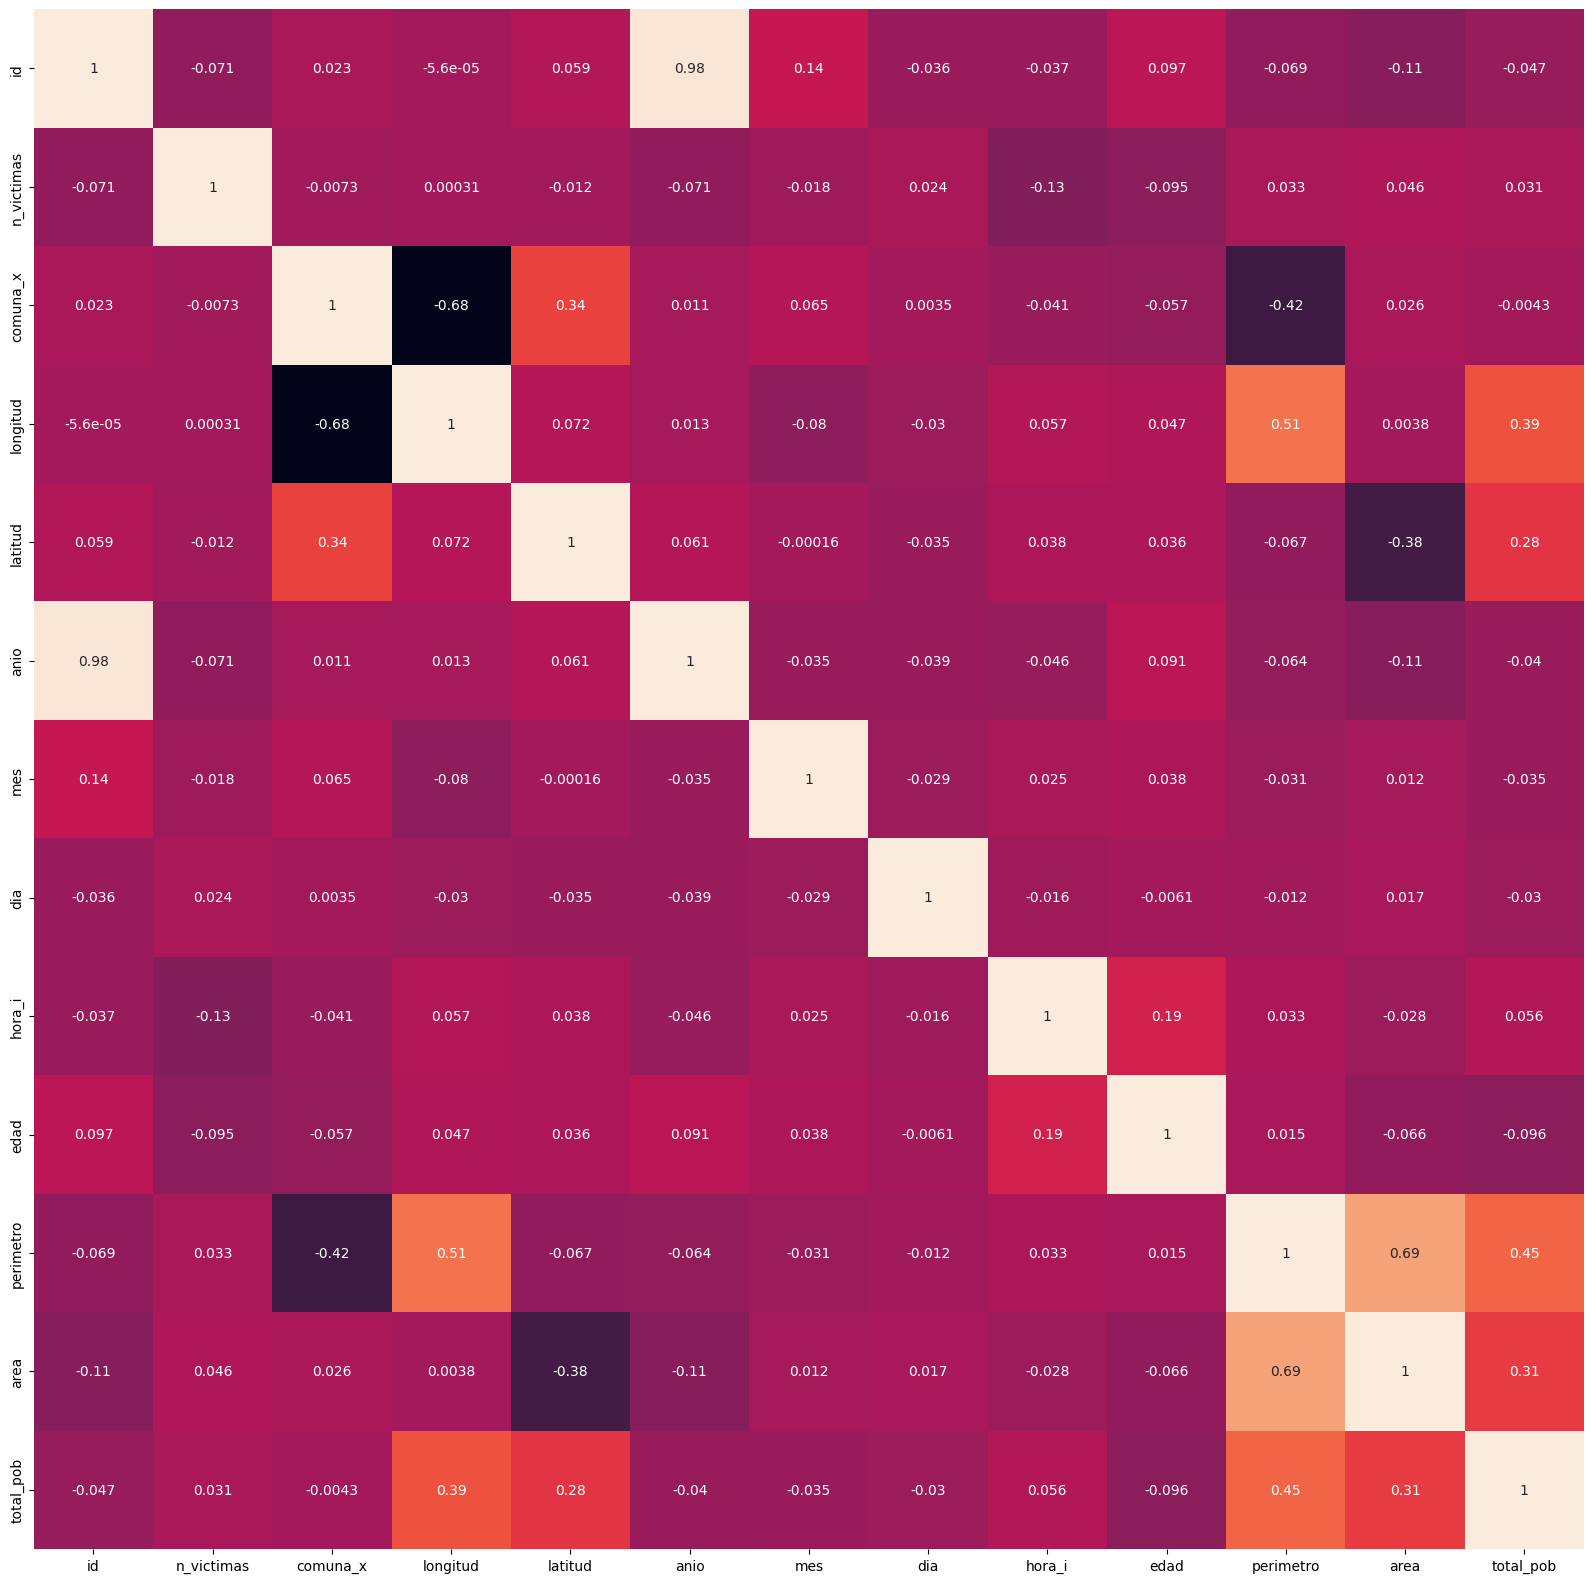

In [34]:
plt.figure(figsize = (20, 20))
corr_matrix = result_df.iloc[:, :13].corr()
sns.heatmap(corr_matrix, annot = True, cbar = False)


1. **Correlación Positiva Muy Fuerte:**
   - La variable "anio" tiene una correlación positiva muy fuerte con la variable "id" (0.98). Esto indica una fuerte relación lineal positiva entre el año y el identificador.

2. **Correlación Negativa Moderada:**
   - La variable "comuna_x" y "longitud" tienen una correlación negativa moderada de -0.68. Esto podría indicar que hay alguna relación inversa entre la comuna y la longitud.

3. **Correlación Baja o No Significativa:**
   - En general, la mayoría de las variables tienen correlaciones bajas o no significativas entre sí.

4. **Impacto de Variables en "total_pob":**
   - La variable "area" tiene una correlación positiva considerable con "total_pob" (0.31), lo que sugiere que a medida que aumenta el área, también lo hace la población total.
   - La variable "perimetro" también muestra una correlación positiva decente con "total_pob" (0.45).

5. **Relación No Lineal:**
   - La correlación no captura relaciones no lineales. Por lo tanto, es importante tener en cuenta que algunas relaciones pueden no ser evidentes en este análisis.

Es esencial recordar que la correlación no implica causalidad.

In [35]:
result_df.drop(['perimetro'], axis=1, inplace=True)

In [36]:
result_df.head(5)

,id,n_victimas,comuna_x,longitud,latitud,anio,mes,dia,hora_i,edad,area,total_pob,t_varon,t_mujer,tipo_de_calle_avenida,tipo_de_calle_calle,tipo_de_calle_gralpaz,acusado_bicicleta,acusado_cargas,acusado_moto,acusado_multiple,acusado_objetofijo,acusado_otro,acusado_pasajeros,acusado_snr,acusado_tren,rol_conductor,rol_pasajero_acompañante,rol_peaton,rol_snr,victima_bicicleta,victima_cargas,victima_moto,victima_movil,victima_pasajeros,victima_peaton,victima_snr,sexo_masculino,sexo_snr,barrios_almagro_boedo,barrios_balvanera_sancristobal,barrios_barracas_boca_nuevapompeya_parquepatricios,barrios_belgrano_colegiales_nunez,barrios_caballito,barrios_coghlan_saavedra_villapueyrredon_villaurquiza,barrios_constitucion_montserrat_puertomadero_retiro_sannicolas_santelmo,barrios_flores_parquechacabuco,barrios_floresta_montecastro_velezsarsfield_versalles_villaluro_villareal,barrios_liniers_mataderos_parqueavellaneda,barrios_palermo,barrios_recoleta,barrios_villadelparque_villadevoto_villagralmitre_villasantarita,barrios_villalugano_villariachuelo_villasoldati
0,0,1,8,-58.475340,-34.687570,2016,1,1,4,19,2.221690e+07,187237,89545,97692,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1,1,9,-58.508775,-34.669777,2016,1,2,1,70,1.650531e+07,161797,76207,85590,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,2,1,1,-58.390403,-34.631894,2016,1,3,7,30,1.779457e+07,205991,98160,107831,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,3,1,8,-58.465039,-34.680930,2016,1,10,0,18,2.221690e+07,187237,89545,97692,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,4,1,1,-58.387183,-34.622466,2016,1,21,5,29,1.779457e+07,205991,98160,107831,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [45]:
result_df.total_pob.value_counts().index
# 2,753,330 Válido Población estimada 2010-  Cabe aclarar de poblacion es una etiqueta

Index([205991, 218245, 161797, 187237, 220591, 187537, 182574, 231331, 200116,
       225970, 189832, 166022, 157827, 176076, 179005],
      dtype='int64', name='total_pob')

In [43]:
import plotly.figure_factory as ff
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

selected_columns = [1, 2, 5, 6, 7, 8, 9]

for col_index in selected_columns:
    col_name = result_df.columns[col_index]
    fig = ff.create_distplot([result_df[col_name].dropna().apply(lambda x: float(x))], ['distplot'])
    fig.update_layout(title_text=col_name)
    fig.show()

<Figure size 1000x1000 with 0 Axes>

In [48]:
# Visualizar la relación entre variables usando parcelas
plt.figure(figsize = (15, 15))

fig = px.scatter_matrix(result_df,
    dimensions = result_df.columns[:10], color = 'edad')

fig.update_layout(
    title = 'Siniestros Data',
    width = 1100,
    height = 1100,
)
fig.show()

<Figure size 1500x1500 with 0 Axes>

In [55]:
# Rellenar los valores faltantes en longitud y latitud con la moda
result_df['longitud'] = result_df['longitud'].fillna(result_df['longitud'].mode()[0])
result_df['latitud'] = result_df['latitud'].fillna(result_df['latitud'].mode()[0])

In [56]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 715 entries, 0 to 714
Data columns (total 53 columns):
 #   Column                                                                     Non-Null Count  Dtype  
---  ------                                                                     --------------  -----  
 0   id                                                                         715 non-null    int16  
 1   n_victimas                                                                 715 non-null    int64  
 2   comuna_x                                                                   715 non-null    int64  
 3   longitud                                                                   715 non-null    float64
 4   latitud                                                                    715 non-null    float64
 5   anio                                                                       715 non-null    int32  
 6   mes                                                       

In [49]:
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

## Clisters Método el codo de `Siniestros Fatales`.

In [57]:
# Escalamos los datos
scaler = StandardScaler()
result_df_scaled = scaler.fit_transform(result_df)

In [58]:
result_df_scaled.shape

(715, 53)

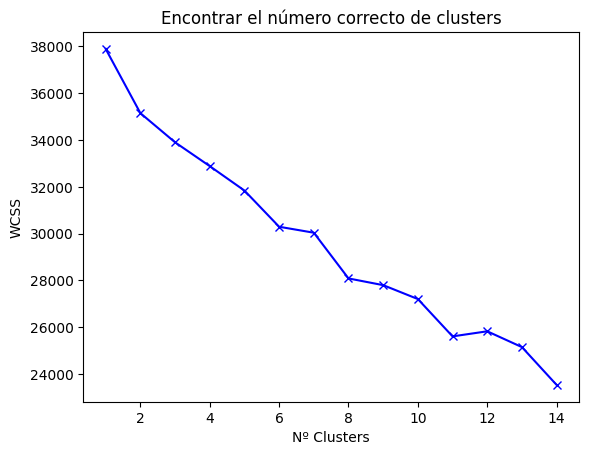

In [59]:
scores = []

range_values = range(1, 15)

for i in range_values:
  kmeans = KMeans(n_clusters = i)
  kmeans.fit(result_df_scaled)
  scores.append(kmeans.inertia_) # la inercia es la suma de los cuadrados de las distancias de las observaciones al centro del cluster más cercano

plt.plot(range_values, scores, 'bx-')
plt.title('Encontrar el número correcto de clusters')
plt.xlabel('Nº Clusters')
plt.ylabel('WCSS')
plt.show()

In [60]:
# Agrupar los datos usando k-means
kmeans = KMeans(5)
kmeans.fit(result_df_scaled)
labels = kmeans.labels_

In [61]:
labels

array([1, 2, 1, 1, 1, 1, 1, 2, 1, 3, 3, 1, 3, 2, 3, 1, 1, 2, 1, 1, 3, 3,
       2, 3, 1, 1, 1, 2, 1, 1, 1, 3, 1, 1, 3, 3, 1, 3, 1, 1, 3, 1, 3, 1,
       3, 3, 2, 3, 2, 4, 1, 2, 2, 3, 3, 3, 1, 1, 2, 1, 3, 3, 3, 0, 2, 1,
       3, 3, 3, 1, 1, 1, 1, 3, 1, 2, 1, 2, 2, 2, 3, 3, 1, 2, 2, 1, 1, 2,
       3, 1, 1, 1, 1, 1, 2, 1, 3, 2, 2, 2, 3, 3, 1, 3, 1, 1, 1, 3, 1, 1,
       3, 1, 1, 1, 1, 3, 1, 3, 3, 1, 1, 1, 3, 2, 2, 1, 1, 1, 2, 3, 3, 1,
       1, 3, 1, 1, 1, 1, 1, 1, 3, 1, 3, 3, 1, 1, 3, 1, 1, 1, 1, 1, 3, 1,
       4, 1, 1, 2, 1, 3, 1, 1, 1, 3, 3, 2, 2, 1, 2, 1, 3, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 3, 2, 2, 1, 2, 1, 1, 1, 3, 3, 1, 4, 2, 3, 1,
       1, 3, 1, 1, 2, 3, 1, 1, 2, 3, 4, 1, 1, 2, 3, 2, 4, 3, 2, 3, 3, 2,
       3, 1, 3, 3, 2, 1, 3, 3, 1, 1, 3, 3, 3, 3, 1, 1, 1, 1, 3, 3, 1, 1,
       3, 4, 1, 1, 1, 2, 3, 1, 1, 2, 1, 4, 3, 2, 1, 1, 3, 1, 3, 3, 1, 2,
       1, 3, 1, 2, 1, 2, 3, 3, 2, 3, 3, 1, 1, 3, 1, 2, 1, 1, 3, 2, 3, 3,
       3, 1, 3, 3, 2, 1, 1, 2, 4, 1, 1, 3, 1, 1, 1,

In [62]:
kmeans.cluster_centers_.shape

(5, 53)

In [63]:
# Echemos un vistazo a los centros de los clústeres
cluster_centers = pd.DataFrame(data = kmeans.cluster_centers_, columns = [result_df.columns])
cluster_centers

,id,n_victimas,comuna_x,longitud,latitud,anio,mes,dia,hora_i,edad,area,total_pob,t_varon,t_mujer,tipo_de_calle_avenida,tipo_de_calle_calle,tipo_de_calle_gralpaz,acusado_bicicleta,acusado_cargas,acusado_moto,acusado_multiple,acusado_objetofijo,acusado_otro,acusado_pasajeros,acusado_snr,acusado_tren,rol_conductor,rol_pasajero_acompañante,rol_peaton,rol_snr,victima_bicicleta,victima_cargas,victima_moto,victima_movil,victima_pasajeros,victima_peaton,victima_snr,sexo_masculino,sexo_snr,barrios_almagro_boedo,barrios_balvanera_sancristobal,barrios_barracas_boca_nuevapompeya_parquepatricios,barrios_belgrano_colegiales_nunez,barrios_caballito,barrios_coghlan_saavedra_villapueyrredon_villaurquiza,barrios_constitucion_montserrat_puertomadero_retiro_sannicolas_santelmo,barrios_flores_parquechacabuco,barrios_floresta_montecastro_velezsarsfield_versalles_villaluro_villareal,barrios_liniers_mataderos_parqueavellaneda,barrios_palermo,barrios_recoleta,barrios_villadelparque_villadevoto_villagralmitre_villasantarita,barrios_villalugano_villariachuelo_villasoldati
0,0.274951,-0.239279,0.239850,-0.048315,-0.552693,0.191382,0.277751,-0.280674,-0.081083,-0.714268,0.339096,-0.231184,-0.150828,-0.291916,0.099797,-0.063374,0.237615,-0.099433,-0.515254,-0.297120,-0.156062,-0.321551,10.870449,-0.575735,-0.173952,-0.037424,0.077152,0.173774,-0.769693,1.300156,0.639271,-0.099433,0.491526,-0.064911,-0.083918,-0.769693,-0.106374,-0.224497,-0.075006,0.786936,-0.262220,0.179194,-0.243432,-0.178174,-0.240192,-0.386675,-0.308134,-0.209274,-0.342327,-0.233607,-0.190347,0.574368,0.822275
1,-0.038002,0.120747,0.033639,0.116344,0.159354,-0.017478,-0.077730,0.004732,-0.201910,-0.408526,0.009751,0.355118,0.345374,0.349963,0.023563,-0.079058,-0.013245,-0.036740,0.083596,-0.037108,0.006007,0.229180,-0.091993,-0.233121,0.063685,-0.037424,0.677697,0.163983,-0.769693,0.012314,-0.096085,0.025954,0.703885,0.030586,-0.009842,-0.769693,0.010999,0.297504,0.090516,-0.017322,0.090011,0.070898,0.052030,0.054167,0.194724,0.026217,0.108632,-0.209274,-0.342327,0.045053,-0.190347,0.118359,-0.025004
2,-0.006207,0.031997,0.382634,-1.169991,-0.874307,-0.052338,0.199546,0.021880,-0.107724,0.120066,0.272853,-1.273915,-1.148883,-1.333424,-0.394838,-0.073222,0.592028,-0.099433,0.189193,-0.126758,-0.003416,-0.002344,-0.091993,-0.091693,0.101520,0.170004,0.022727,0.210661,-0.208360,0.144949,0.030173,0.136762,-0.167338,-0.064911,0.102133,-0.208360,0.188422,-0.060613,-0.075006,-0.178174,-0.262220,-0.352440,-0.243432,-0.178174,-0.240192,-0.386675,-0.308134,0.950656,1.555065,-0.233607,-0.190347,-0.183025,0.263662
3,0.023903,-0.155117,-0.132089,0.382960,0.186299,0.018985,0.013288,0.004085,0.329657,0.465464,0.023824,0.404246,0.396747,0.395267,0.135439,0.184113,-0.282838,0.120402,-0.206919,0.130996,-0.013989,-0.321551,-0.091993,0.385364,-0.122674,-0.037424,-0.925820,-0.327477,1.173830,-0.119098,0.057732,-0.099433,-0.857576,0.002061,-0.031969,1.173830,-0.106374,-0.366860,-0.075006,0.122639,0.055376,0.130864,0.095634,0.047436,-0.106752,0.231055,0.061059,-0.209274,-0.342327,0.098614,-0.190347,-0.054913,-0.098728
4,0.237684,-0.239279,-1.247412,1.002379,0.857435,0.275221,-0.211723,-0.144619,0.146033,0.545484,-1.835809,-1.708670,-2.177557,-1.237259,0.456574,-0.283582,-0.326820,-0.099433,-0.024045,-0.004098,0.106489,0.090226,-0.091993,0.071805,-0.173952,-0.037424,-0.364156,-0.228051,0.388898,-0.119098,0.402705,-0.099433,-0.452846,-0.064911,-0.083918,0.388898,-0.106374,-0.099217,-0.075006,-0.178174,-0.262220,-0.352440,-0.243432,-0.178174,-0.240192,-0.386675,-0.308134,-0.209274,-0.342327,-0.233607,5.253570,-0.219971,-0.321551


In [64]:
# Para entender lo que significan estos números, realicemos una transformación inversa
cluster_centers = scaler.inverse_transform(cluster_centers)
cluster_centers = pd.DataFrame(data = cluster_centers, columns = [result_df.columns])
cluster_centers

# Clúster 0 (más alto): este grupo representa a los clientes que compran artículos en una gran cantidad centrada en ~ 47, compran artículos en todos los rangos de precios inclinándose hacia artículos de alto precio de ~ 99. También corresponden a las ventas totales más altas alrededor de ~ 8296 y están activas durante todo el año. Son los mayores compradores de productos con un MSRP alto ~ 158.
# Clúster 1: este grupo representa a los clientes que compran artículos en cantidades variables ~ 35, tienden a comprar artículos de alto precio ~ 96. Sus ventas son un poco mejores en promedio ~ 4435, compran productos con el segundo MSRP más alto de ~ 133.
# Clúster 2 (más bajo): este grupo representa a los clientes que compran artículos en cantidades bajas ~ 30. Suelen comprar artículos de bajo precio ~ 68. Sus ventas ~ 2044 son más bajas que las de otros grupos y son extremadamente activos durante la temporada navideña. Compran productos con un MSRP bajo ~ 75.
# Clúster 3: este grupo representa a los clientes que solo están activos durante las vacaciones. compran en menor cantidad ~ 35, pero tienden a comprar artículos de precio promedio alrededor de ~ 86. También corresponden a ventas totales más bajas alrededor de ~ 3673, tienden a comprar artículos con MSRP alrededor de 102.
# Clúster 4: este grupo representa a los clientes que compran artículos en cantidad variable ~ 39, tienden a comprar artículos de precio promedio ~ 94. Sus ventas ~ 4280.

,id,n_victimas,comuna_x,longitud,latitud,anio,mes,dia,hora_i,edad,area,total_pob,t_varon,t_mujer,tipo_de_calle_avenida,tipo_de_calle_calle,tipo_de_calle_gralpaz,acusado_bicicleta,acusado_cargas,acusado_moto,acusado_multiple,acusado_objetofijo,acusado_otro,acusado_pasajeros,acusado_snr,acusado_tren,rol_conductor,rol_pasajero_acompañante,rol_peaton,rol_snr,victima_bicicleta,victima_cargas,victima_moto,victima_movil,victima_pasajeros,victima_peaton,victima_snr,sexo_masculino,sexo_snr,barrios_almagro_boedo,barrios_balvanera_sancristobal,barrios_barracas_boca_nuevapompeya_parquepatricios,barrios_belgrano_colegiales_nunez,barrios_caballito,barrios_coghlan_saavedra_villapueyrredon_villaurquiza,barrios_constitucion_montserrat_puertomadero_retiro_sannicolas_santelmo,barrios_flores_parquechacabuco,barrios_floresta_montecastro_velezsarsfield_versalles_villaluro_villareal,barrios_liniers_mataderos_parqueavellaneda,barrios_palermo,barrios_recoleta,barrios_villadelparque_villadevoto_villagralmitre_villasantarita,barrios_villalugano_villariachuelo_villasoldati
0,399.666667,1.000000,8.500000,-58.443931,-34.640542,2018.500000,7.666667,13.500000,11.000000,23.333333,1.687033e+07,190688.333333,89336.000000,101352.333333,0.666667,0.166667,1.666667e-01,0.000000e+00,0.000000,0.000000,-3.469447e-18,1.387779e-17,1.000000e+00,0.000000,3.469447e-18,0.000000e+00,5.000000e-01,0.166667,5.551115e-17,1.666667e-01,0.166667,1.734723e-18,6.666667e-01,0.000000e+00,0.000000,5.551115e-17,0.000000e+00,0.666667,0.000000e+00,1.666667e-01,0.000000e+00,1.666667e-01,0.000000e+00,3.469447e-18,6.938894e-18,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.938894e-18,6.938894e-18,1.666667e-01,0.333333
1,337.299383,1.092593,7.598765,-58.436356,-34.614980,2018.151235,6.398148,15.975309,10.191358,30.077160,1.527229e+07,203728.472222,94564.808642,109163.663580,0.629630,0.160494,9.259259e-02,6.172840e-03,0.243827,0.070988,2.469136e-02,1.604938e-01,2.602085e-17,0.148148,4.012346e-02,3.903128e-18,7.993827e-01,0.163580,7.216450e-16,1.543210e-02,0.021605,1.234568e-02,7.716049e-01,6.172840e-03,0.006173,7.216450e-16,1.234568e-02,0.888889,1.234568e-02,2.777778e-02,8.641975e-02,1.327160e-01,6.790123e-02,4.012346e-02,9.876543e-02,1.388889e-01,1.172840e-01,9.020562e-17,-1.110223e-16,6.172840e-02,6.938894e-17,7.098765e-02,0.086420
2,343.635659,1.069767,9.124031,-58.495537,-34.652087,2018.093023,7.387597,16.124031,10.821705,41.736434,1.654891e+07,167496.550388,78818.829457,88677.720930,0.426357,0.162791,2.713178e-01,-1.734723e-18,0.286822,0.046512,2.325581e-02,9.302326e-02,-3.469447e-18,0.209302,4.651163e-02,7.751938e-03,4.728682e-01,0.178295,2.713178e-01,3.100775e-02,0.046512,2.325581e-02,3.410853e-01,2.602085e-18,0.015504,2.713178e-01,3.100775e-02,0.736434,7.806256e-18,2.428613e-17,-5.551115e-17,1.249001e-16,-4.857226e-17,2.775558e-17,-6.245005e-17,-1.942890e-16,1.387779e-17,2.325581e-01,5.813953e-01,4.163336e-17,-2.081668e-17,7.751938e-03,0.170543
3,349.636364,1.021645,6.874459,-58.424089,-34.614013,2018.212121,6.722944,15.969697,13.748918,49.354978,1.534057e+07,204821.160173,95106.160173,109715.000000,0.683983,0.264069,1.298701e-02,2.164502e-02,0.125541,0.116883,2.164502e-02,1.249001e-16,1.734723e-17,0.415584,8.658009e-03,3.035766e-18,1.665335e-16,0.008658,9.393939e-01,-5.204170e-18,0.051948,8.673617e-18,-8.881784e-16,4.329004e-03,0.004329,9.393939e-01,-1.734723e-17,0.606061,-6.938894e-18,5.194805e-02,7.792208e-02,1.515152e-01,7.792208e-02,3.896104e-02,3.030303e-02,2.077922e-01,1.038961e-01,-4.163336e-17,1.526557e-16,7.359307e-02,3.469447e-17,3.463203e-02,0.064935
4,392.240000,1.000000,2.000000,-58.395591,-34.589920,2018.640000,5.920000,14.680000,12.520000,51.120000,6.317265e+06,157827.000000,67979.000000,89848.000000,0.840000,0.080000,1.387779e-17,1.734723e-18,0.200000,0.080000,4.000000e-02,1.200000e-01,0.000000e+00,0.280000,3.469447e-18,-2.168404e-19,2.800000e-01,0.040000,5.600000e-01,-3.469447e-18,0.120000,0.000000e+00,2.000000e-01,8.673617e-19,0.000000,5.600000e-01,0.000000e+00

In [65]:
labels.shape # Etiquetas del clúster asociado a cada observación

(715,)

In [66]:
labels.max()

4

In [67]:
labels.min()

0

In [69]:
y_kmeans = kmeans.fit_predict(result_df_scaled)
y_kmeans

array([1, 4, 2, 1, 2, 1, 1, 4, 2, 3, 3, 2, 3, 4, 3, 1, 2, 1, 1, 1, 3, 3,
       1, 3, 1, 2, 1, 3, 1, 1, 1, 3, 1, 0, 3, 3, 2, 3, 2, 0, 3, 1, 0, 0,
       3, 3, 3, 3, 1, 1, 1, 1, 1, 3, 3, 3, 1, 0, 4, 1, 3, 3, 3, 2, 3, 2,
       3, 0, 3, 0, 1, 1, 1, 3, 1, 1, 1, 4, 4, 4, 3, 3, 2, 4, 4, 1, 2, 4,
       0, 1, 1, 0, 2, 1, 4, 1, 3, 1, 1, 1, 3, 3, 2, 2, 1, 0, 1, 0, 2, 1,
       0, 0, 0, 2, 1, 3, 0, 3, 2, 1, 2, 1, 3, 1, 3, 1, 1, 1, 4, 0, 3, 1,
       2, 2, 2, 1, 1, 2, 1, 1, 3, 2, 0, 3, 1, 2, 3, 0, 1, 1, 1, 2, 2, 1,
       3, 2, 0, 4, 2, 3, 1, 2, 2, 3, 3, 4, 4, 1, 1, 1, 0, 2, 2, 2, 1, 1,
       2, 1, 0, 1, 0, 1, 1, 3, 4, 4, 1, 3, 2, 1, 1, 3, 3, 1, 3, 1, 3, 2,
       2, 3, 1, 1, 4, 3, 1, 1, 4, 3, 3, 0, 1, 4, 2, 4, 3, 3, 4, 3, 3, 4,
       1, 1, 3, 0, 4, 0, 0, 3, 0, 1, 0, 2, 3, 0, 0, 1, 1, 1, 3, 2, 1, 1,
       3, 1, 1, 1, 2, 4, 3, 1, 1, 1, 1, 1, 3, 4, 1, 1, 3, 1, 3, 3, 1, 1,
       2, 3, 1, 1, 1, 4, 3, 3, 4, 2, 2, 1, 1, 3, 3, 4, 1, 2, 3, 4, 3, 2,
       3, 0, 3, 3, 4, 2, 2, 1, 3, 1, 1, 3, 2, 2, 2,

In [70]:
y_kmeans.shape

(715,)

In [71]:
# Agregar una etiqueta (qué clúster) correspondiente a cada punto de datos
sale_df_cluster = pd.concat([result_df, pd.DataFrame({'cluster':labels})], axis = 1)
sale_df_cluster

,id,n_victimas,comuna_x,longitud,latitud,anio,mes,dia,hora_i,edad,area,total_pob,t_varon,t_mujer,tipo_de_calle_avenida,tipo_de_calle_calle,tipo_de_calle_gralpaz,acusado_bicicleta,acusado_cargas,acusado_moto,acusado_multiple,acusado_objetofijo,acusado_otro,acusado_pasajeros,acusado_snr,acusado_tren,rol_conductor,rol_pasajero_acompañante,rol_peaton,rol_snr,victima_bicicleta,victima_cargas,victima_moto,victima_movil,victima_pasajeros,victima_peaton,victima_snr,sexo_masculino,sexo_snr,barrios_almagro_boedo,barrios_balvanera_sancristobal,barrios_barracas_boca_nuevapompeya_parquepatricios,barrios_belgrano_colegiales_nunez,barrios_caballito,barrios_coghlan_saavedra_villapueyrredon_villaurquiza,barrios_constitucion_montserrat_puertomadero_retiro_sannicolas_santelmo,barrios_flores_parquechacabuco,barrios_floresta_montecastro_velezsarsfield_versalles_villaluro_villareal,barrios_liniers_mataderos_parqueavellaneda,barrios_palermo,barrios_recoleta,barrios_villadelparque_villadevoto_villagralmitre_villasantarita,barrios_villalugano_villariachuelo_villasoldati,cluster
0,0,1,8,-58.475340,-34.687570,2016,1,1,4,19,2.221690e+07,187237,89545,97692,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
1,1,1,9,-58.508775,-34.669777,2016,1,2,1,70,1.650531e+07,161797,76207,85590,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2
2,2,1,1,-58.390403,-34.631894,2016,1,3,7,30,1.779457e+07,205991,98160,107831,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
3,3,1,8,-58.465039,-34.680930,2016,1,10,0,18,2.221690e+07,187237,89545,97692,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
4,4,1,1,-58.387183,-34.622466,2016,1,21,5,29,1.779457e+07,205991,98160,107831,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
710,689,1,7,-58.433538,-34.645616,2021,12,13,17,18,1.242290e+07,220591,102481,118110,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
711,690,1,9,-58.467398,-34.651178,2021,12,20,1,43,1.650531e+07,161797,76207,85590,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2
712,691,1,11,-58.472934,-34.619847,2021,12,30,0,27,1.412004e+07,189832,88469,101363,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
713,692,1,9,-58.470668,-34.650217,2021,12,15,10,60,1.650531e+07,161797,76207,85590,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2


In [72]:
result_df['id'] = result_df['id'].apply(lambda x: float(x))

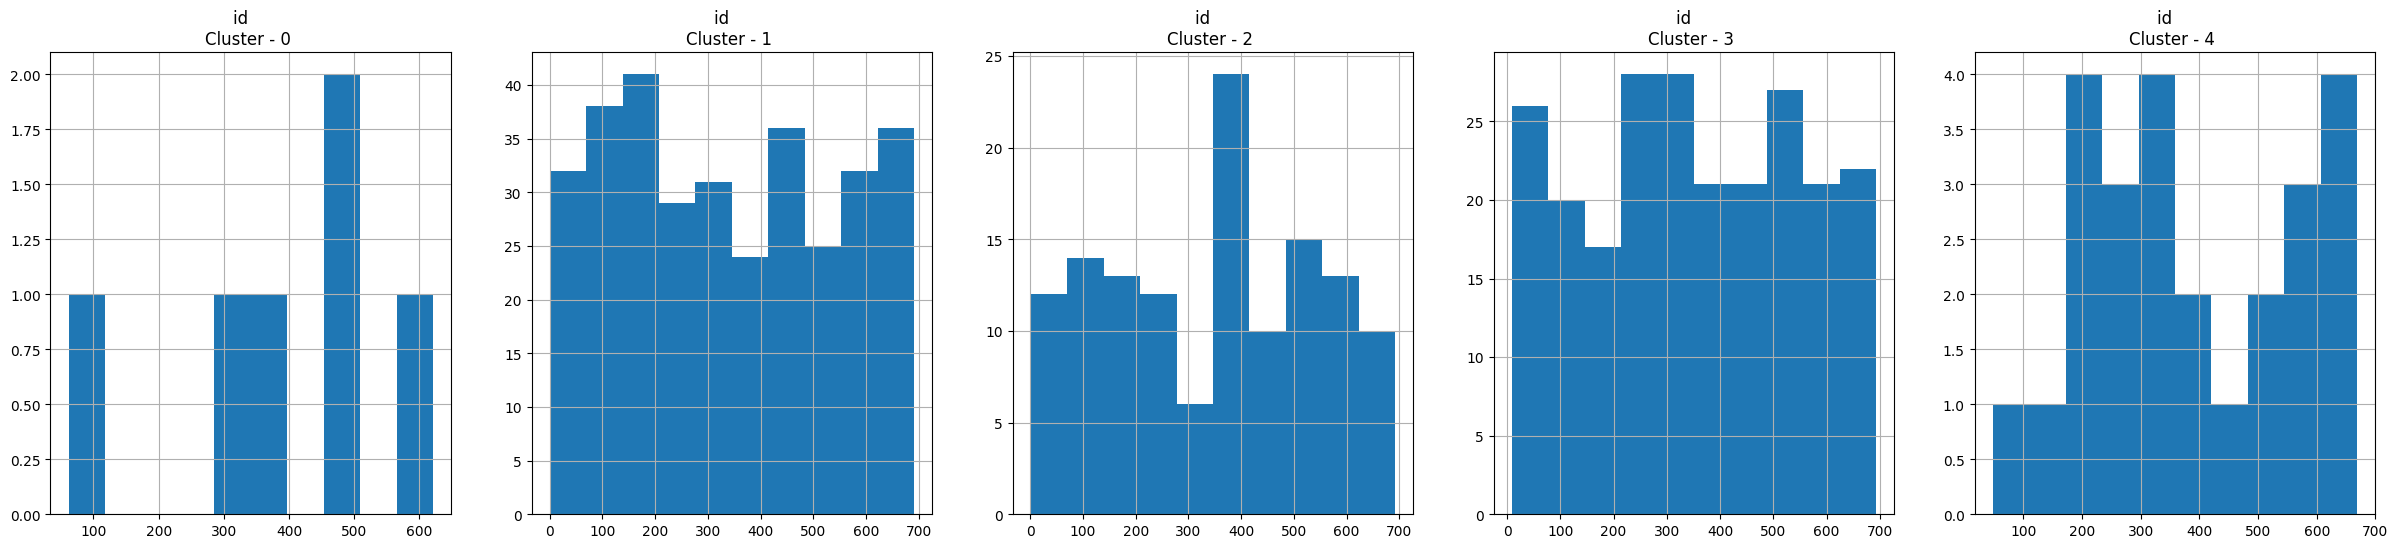

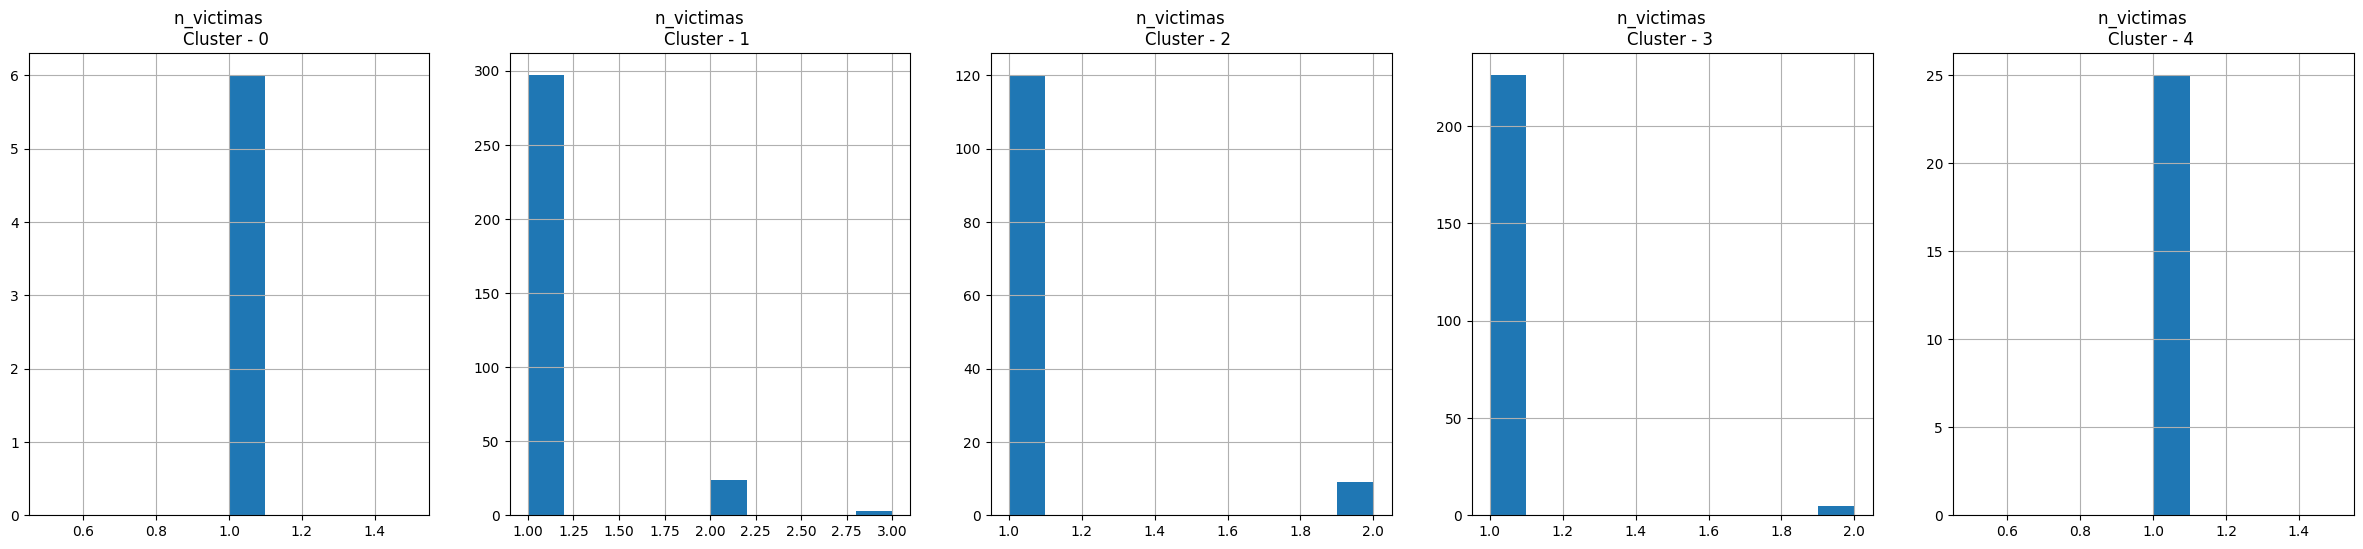

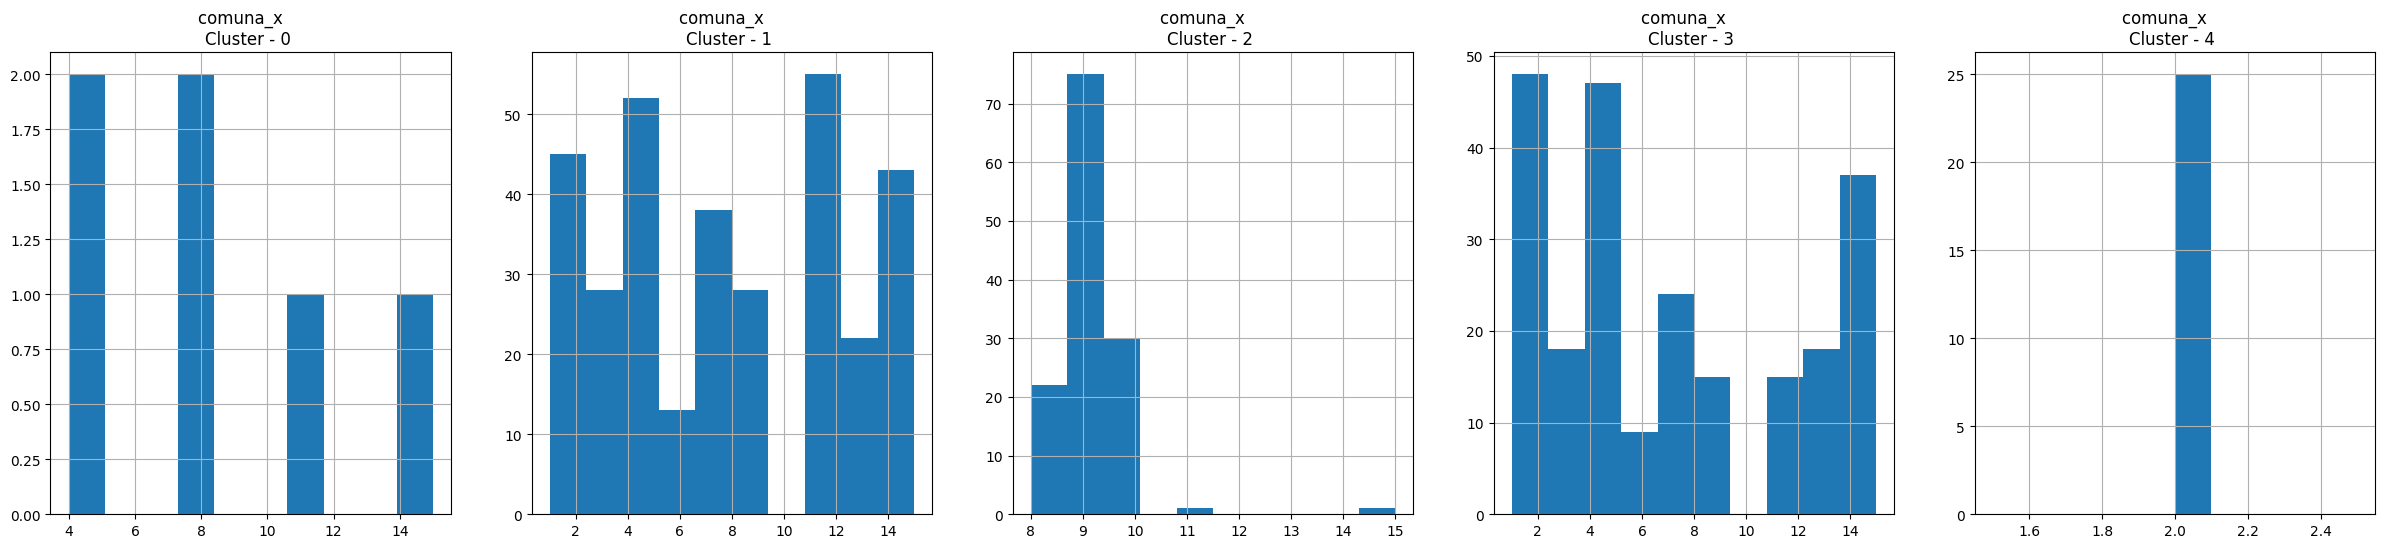

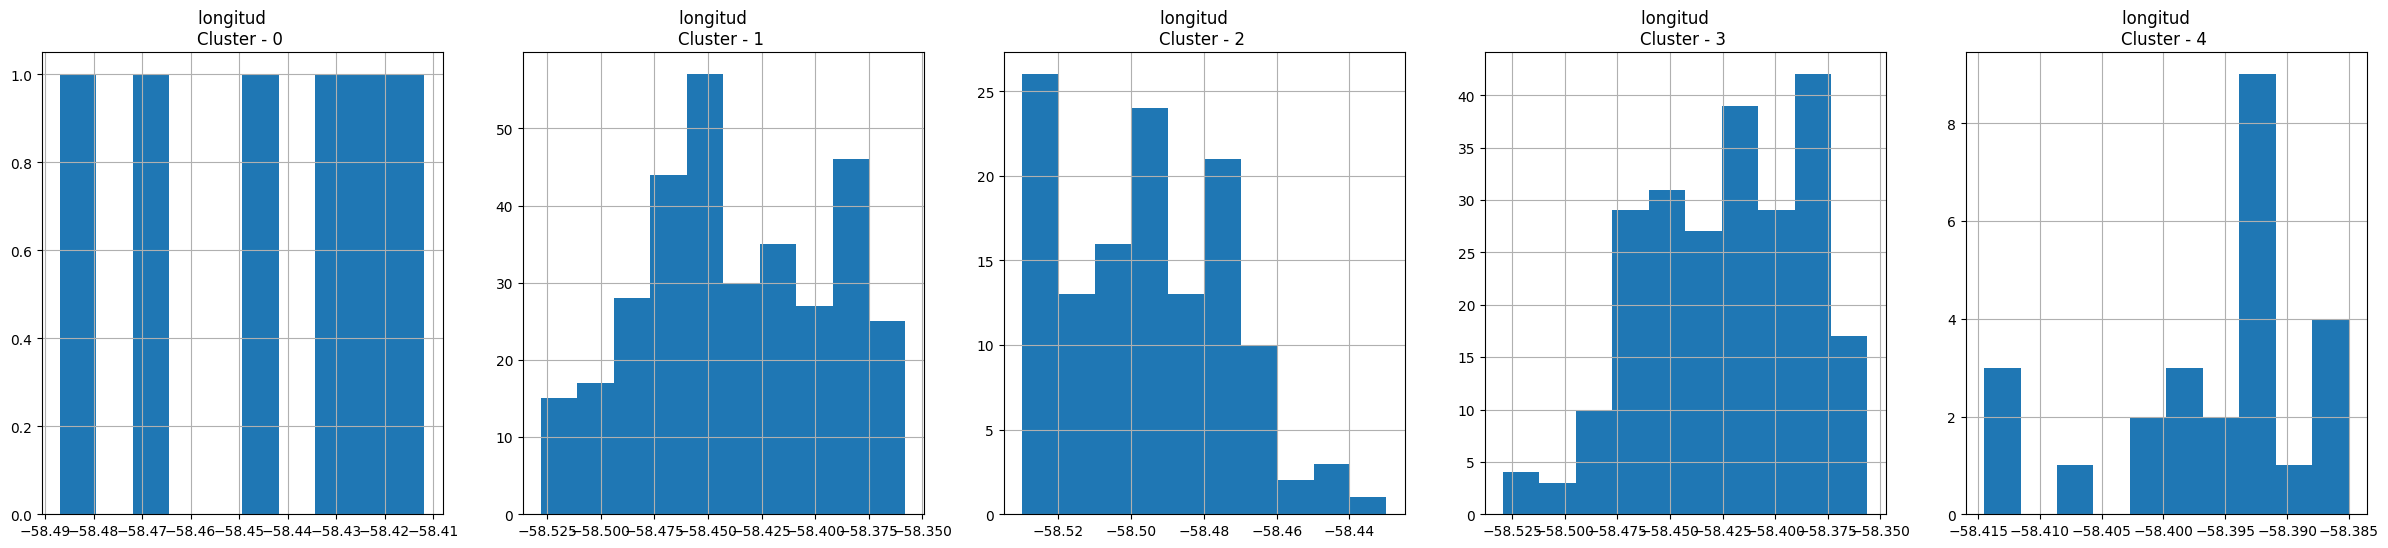

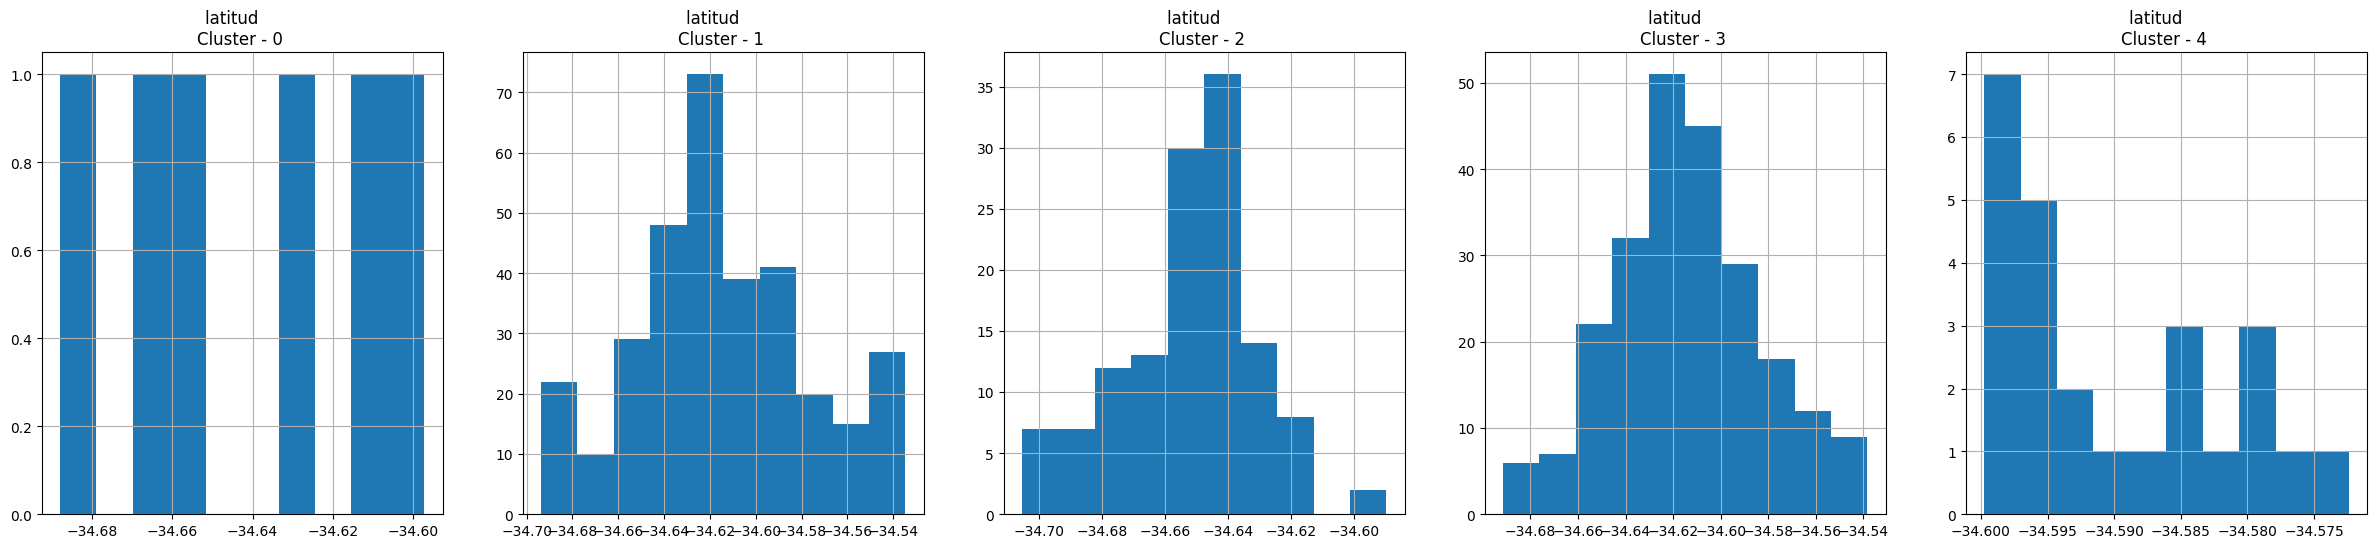

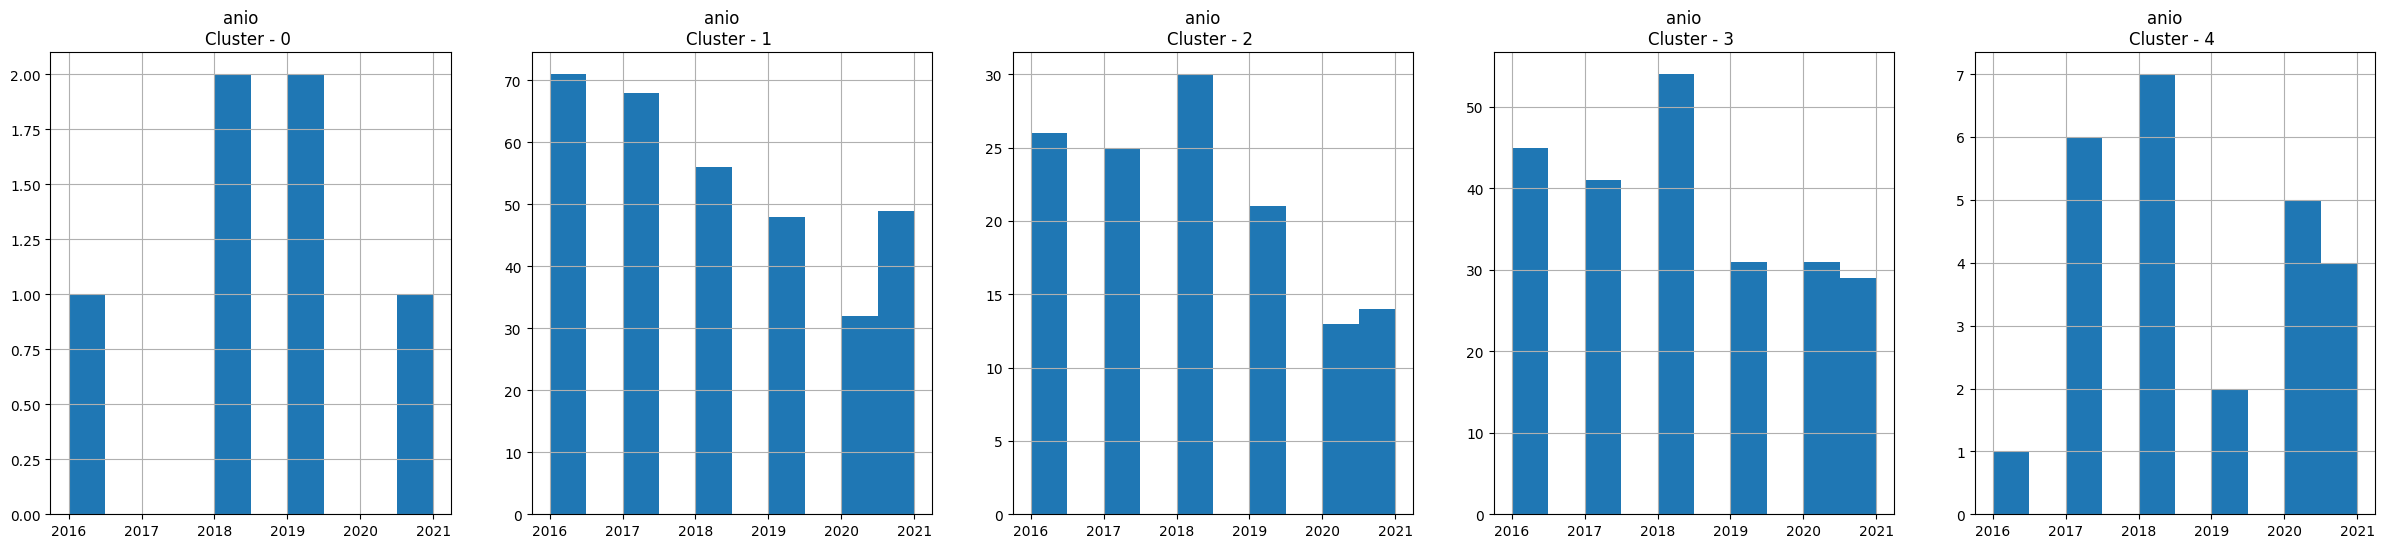

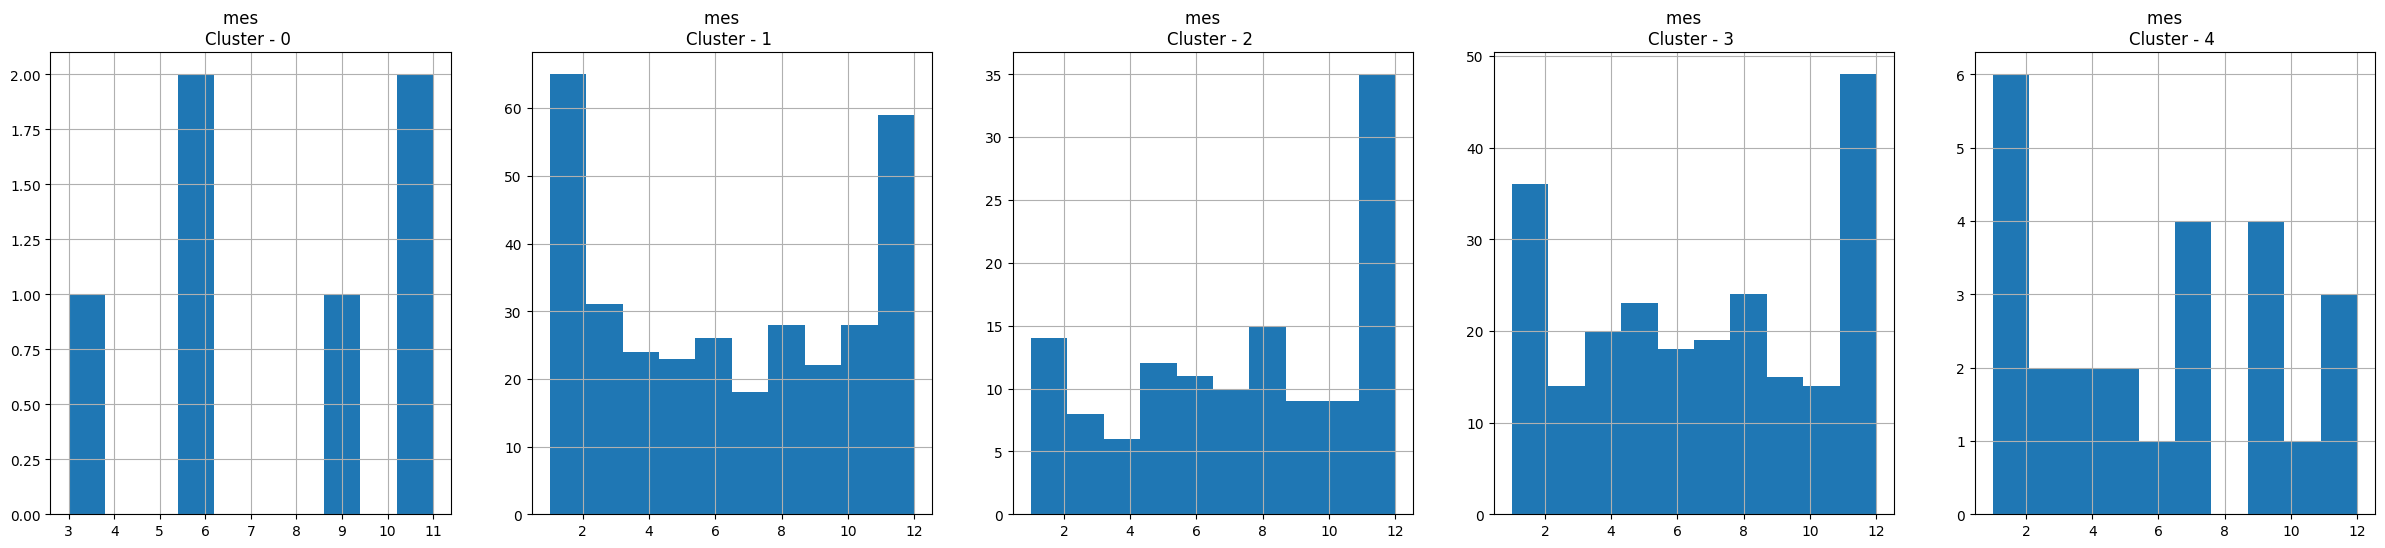

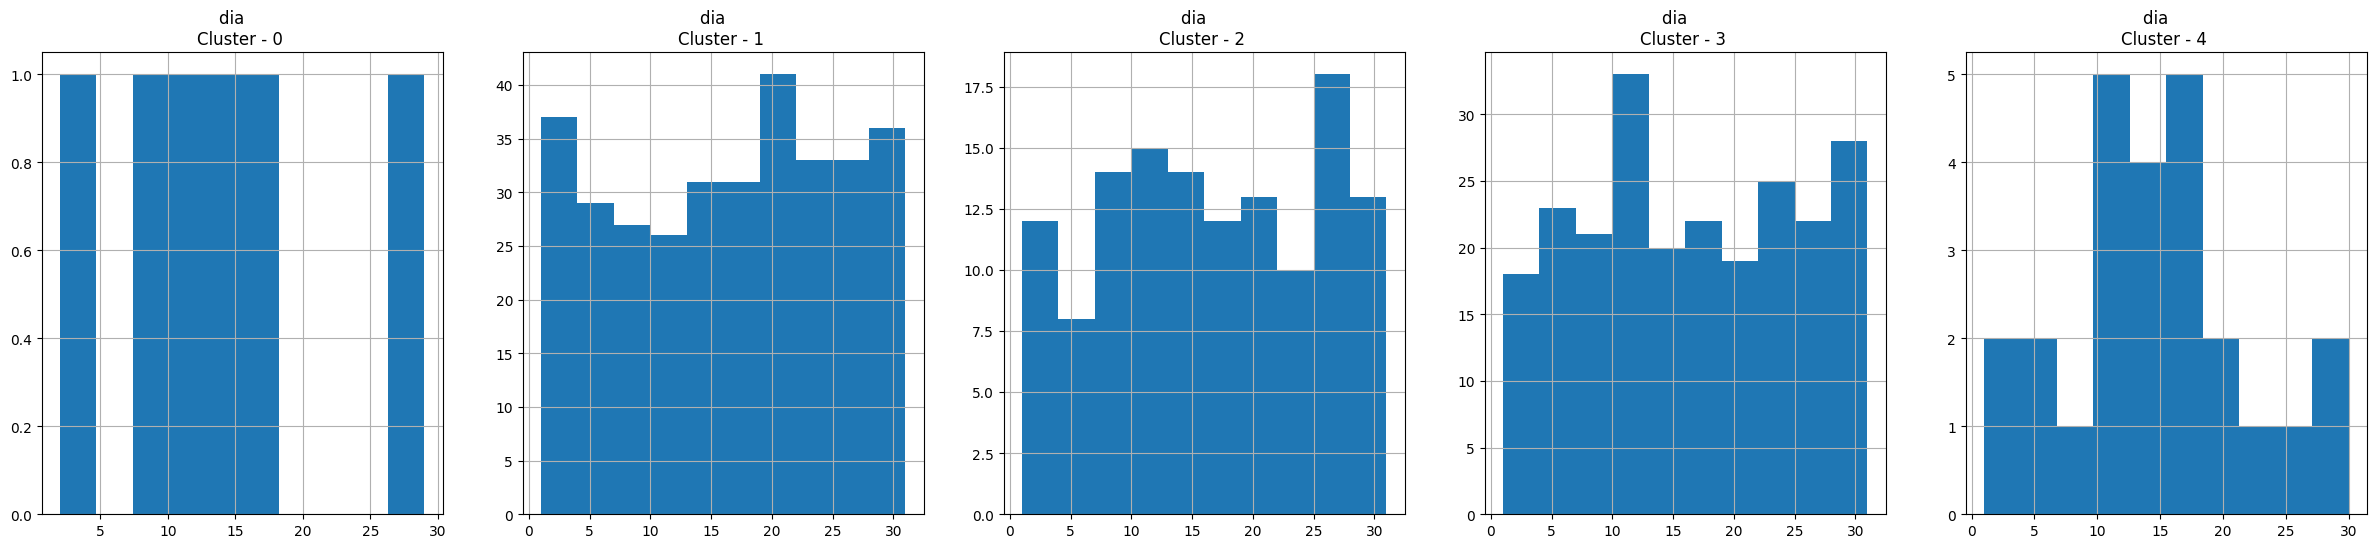

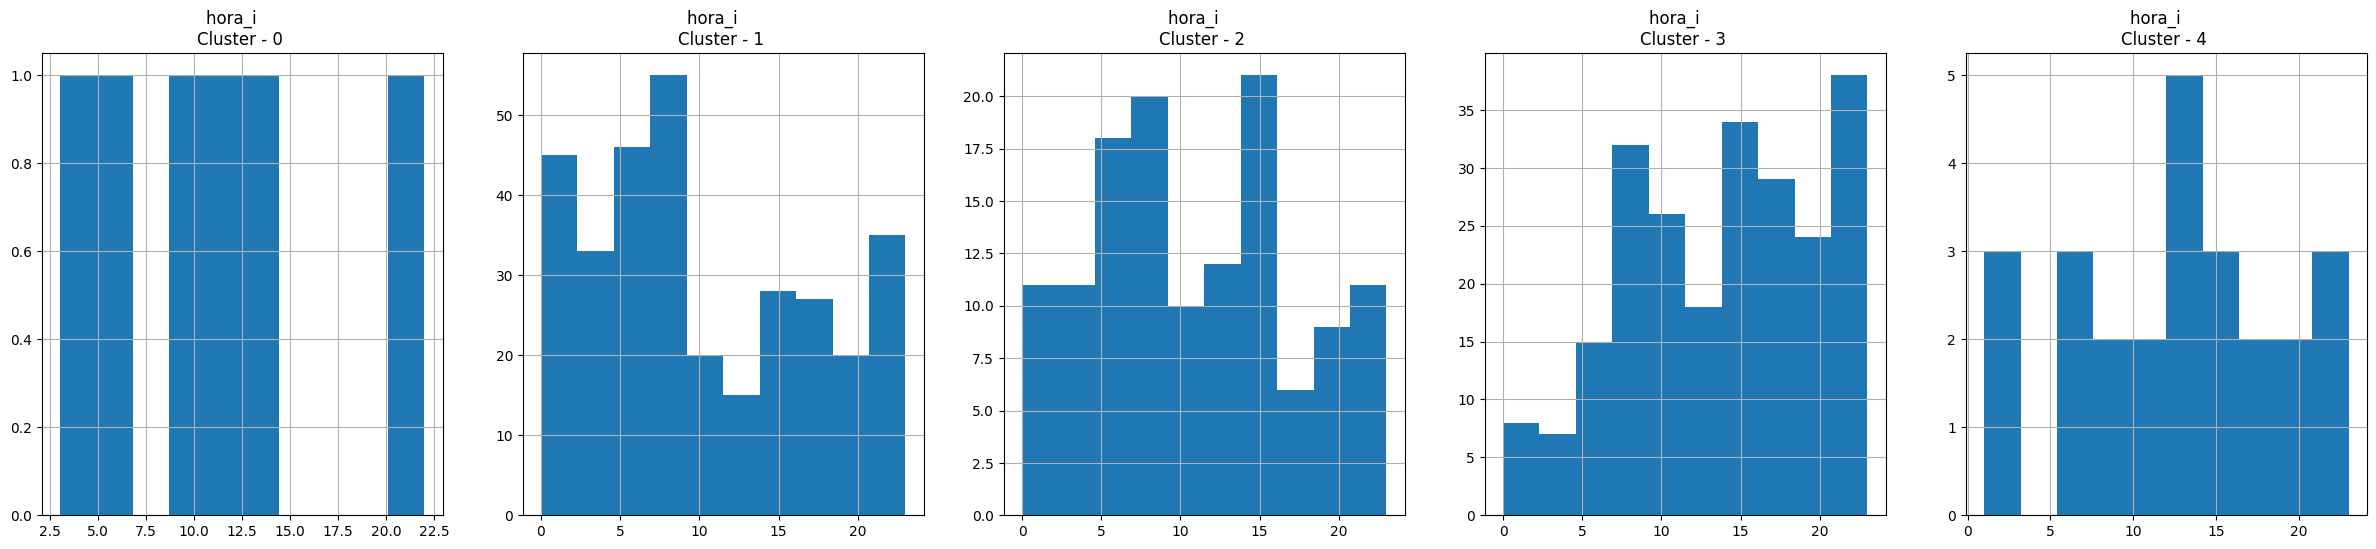

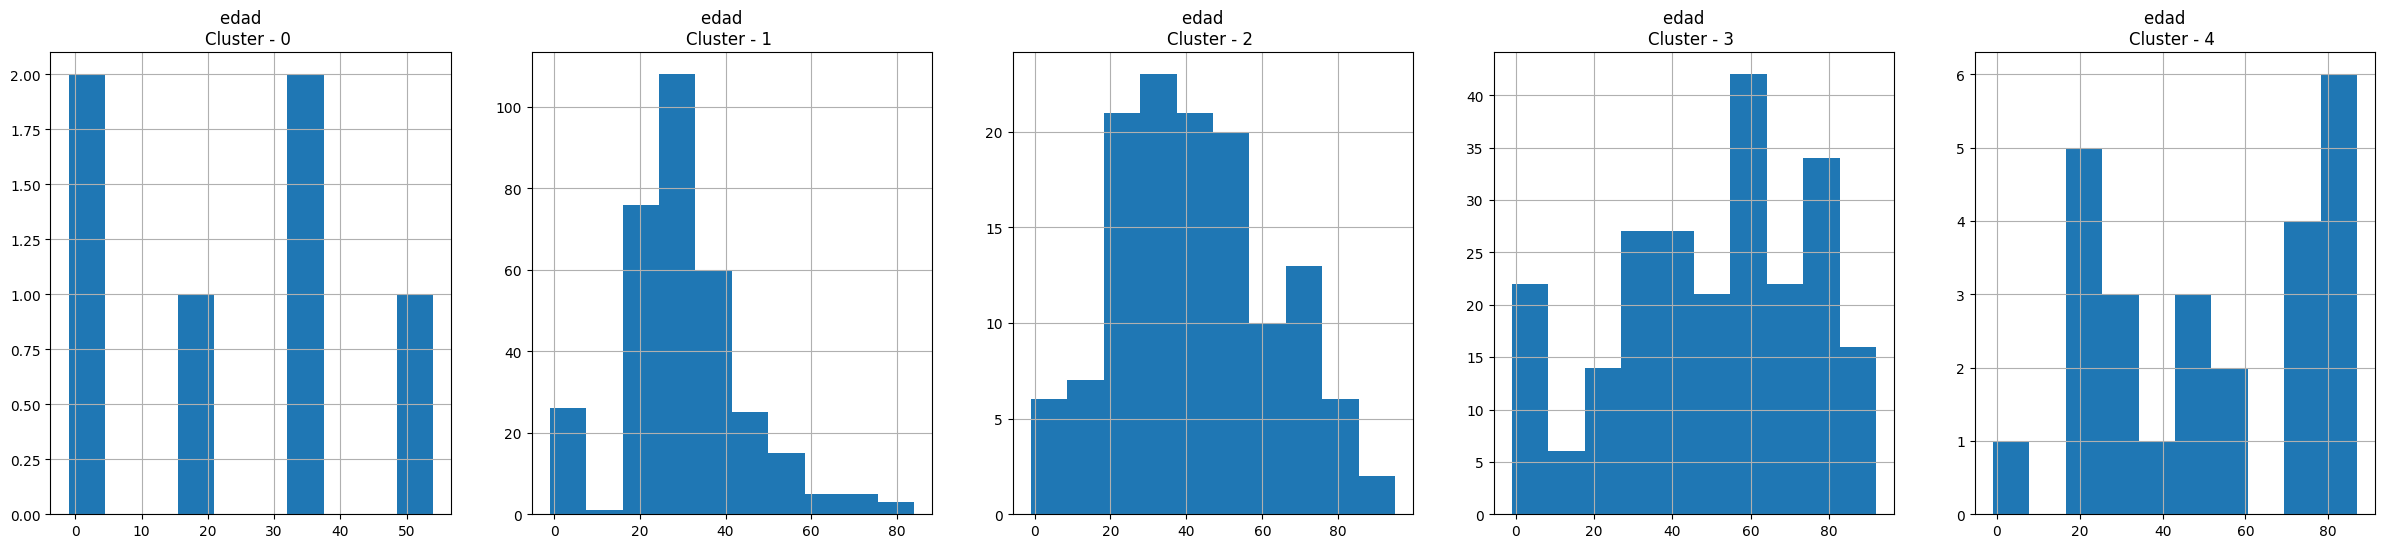

In [75]:
# Representar un histograma para cada característica según el clúster al que pertenece
for i in result_df.columns[:10]:
  plt.figure(figsize = (30, 6))
  for j in range(5):
    plt.subplot(1, 5, j+1)
    cluster = sale_df_cluster[sale_df_cluster['cluster'] == j]
    cluster[i].hist()
    plt.title('{}    \nCluster - {} '.format(i,j))

  plt.show()

## Análisis de Componentes Principales y Vizualizar los datos

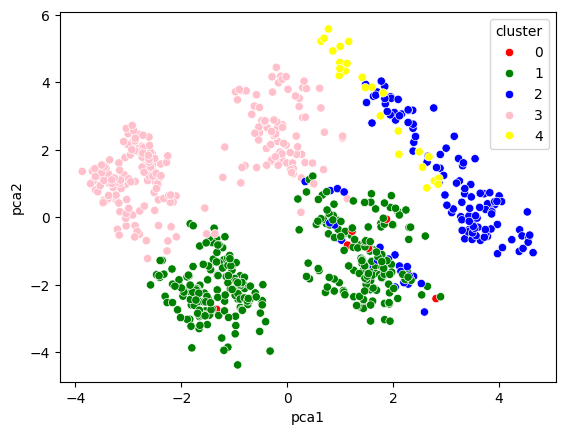

In [76]:
pca = PCA(n_components = 2)
principal_comp = pca.fit_transform(result_df_scaled)

pca_df = pd.DataFrame(data = principal_comp, columns = ['pca1', 'pca2'])
pca_df = pd.concat([pca_df, pd.DataFrame({'cluster':labels})], axis = 1)

ax = sns.scatterplot(x = "pca1", y = "pca2", hue = "cluster", data = pca_df, palette = ["red", "green", "blue", "pink", "yellow"])
plt.show()

In [41]:
# Agrupar por año y mes, y sumar el número de víctimas
rel_tiempo = homicidios_lm.groupby(['anio', 'mes'])['n_victimas'].sum().reset_index()
# Combinar AÑO y MES para obtener una sola variable de tiempo, creando la columna "Fecha" como str
rel_tiempo["fecha"] = rel_tiempo["anio"].astype(str) + '-' + rel_tiempo["mes"].astype(str)
# Convertir la variable de tiempo a formato datetime
rel_tiempo["fecha"] = pd.to_datetime(rel_tiempo["fecha"])
rel_tiempo.head(5)

,anio,mes,n_victimas,fecha
0,2016,1,8,2016-01-01
1,2016,2,12,2016-02-01
2,2016,3,13,2016-03-01
3,2016,4,11,2016-04-01
4,2016,5,7,2016-05-01


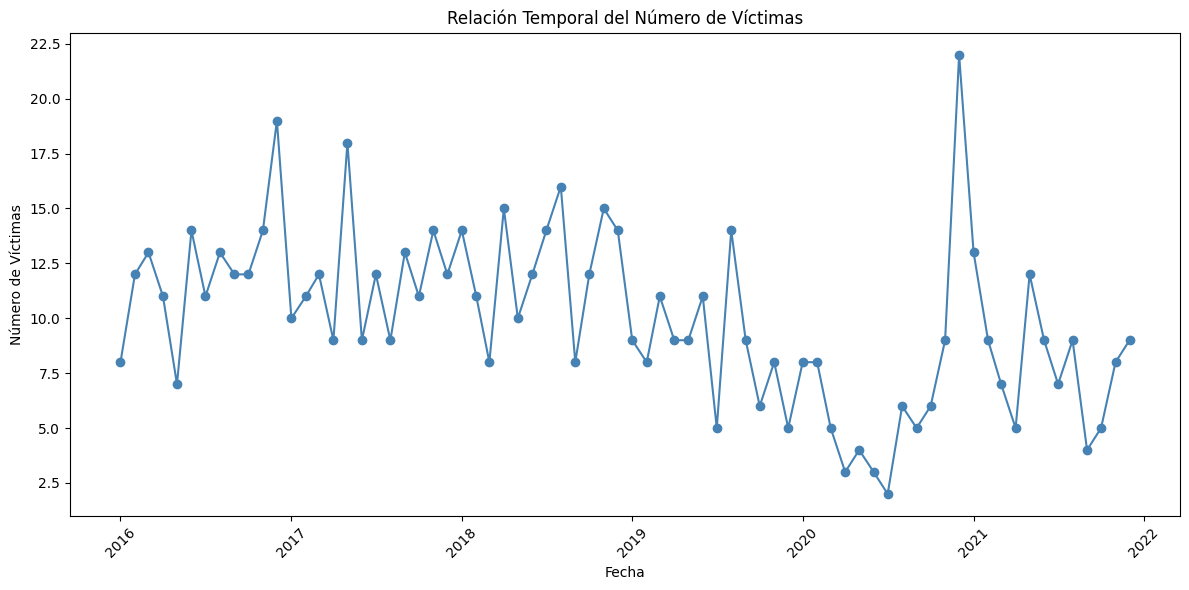

In [42]:
# Crear el gráfico de líneas
plt.figure(figsize=(12, 6))
plt.plot(rel_tiempo["fecha"], rel_tiempo["n_victimas"], marker='o', color='steelblue')

# Añadir títulos y etiquetas
plt.title('Relación Temporal del Número de Víctimas')
plt.xlabel('Fecha')
plt.ylabel('Número de Víctimas')

# Rotar las etiquetas del eje x para mejor legibilidad
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

C:\Users\ozi\AppData\Local\Temp\ipykernel_5292\3730978411.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='mes', y='n_victimas', data=data, palette="winter")


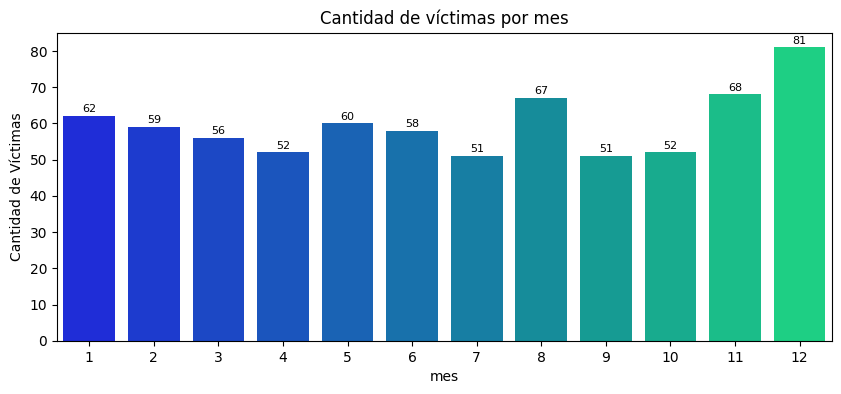

In [44]:
# Se agrupa por la cantidad de víctimas por mes
data = homicidios_lm.groupby(['mes'])['n_victimas'].sum().reset_index()
data["mes"]=data["mes"].astype("Int64")

# Se grafica
plt.figure(figsize=(10,4))

ax = sns.barplot(x='mes', y='n_victimas', data=data, palette="winter")
ax.set_title('Cantidad de víctimas por mes')
ax.set_xlabel('mes') ; ax.set_ylabel('Cantidad de Víctimas')

# Agregar etiquetas de número de víctimas en cada barra
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                textcoords='offset points')

# Se muestra el gráfico
plt.show()

In [46]:
data.n_victimas.sum()


717

C:\Users\ozi\AppData\Local\Temp\ipykernel_5292\1403679157.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='dia', y='n_victimas', data=data, palette="winter")


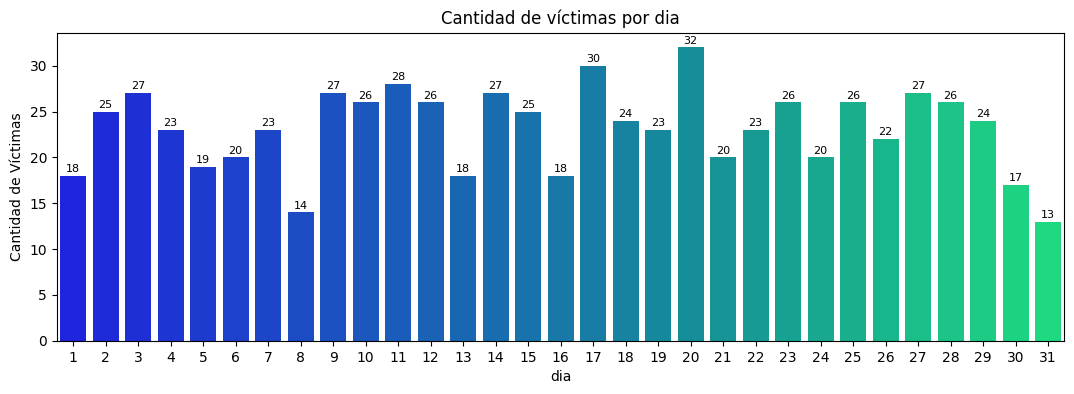

In [48]:
# Se agrupa por la cantidad de víctimas por dia
data = homicidios_lm.groupby(['dia'])['n_victimas'].sum().reset_index()
data["dia"]=data["dia"].astype("Int64")

# Se grafica
plt.figure(figsize=(13,4))

ax = sns.barplot(x='dia', y='n_victimas', data=data, palette="winter")
ax.set_title('Cantidad de víctimas por dia')
ax.set_xlabel('dia') ; ax.set_ylabel('Cantidad de Víctimas')

# Agregar etiquetas de número de víctimas en cada barra
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                textcoords='offset points')

# Se muestra el gráfico
plt.show()

In [67]:
# Se agrupa por la cantidad de víctimas por fecha_formato
data = homicidios_lm.groupby(['fecha_hora'])['n_victimas'].sum().reset_index()
#data["fecha_formato"]=data["fecha_formato"].astype("Int64")
#Creo una columna nueva `Día semana` que contenga el nombre del día de la semana
data['dia_sem'] = data['fecha_hora'].dt.strftime('%A')
#Creo un diccionario para modificar a español los nombres de los dás de la semana y lo aplico a la columna nueva
dic={  'Friday':'Viernes',
       'Saturday': 'Sabado',
       'Sunday': 'Domingo',  
       'Thursday': 'Jueves',
        'Monday': 'Lunes',
        'Wednesday': 'Miercoles',
       'Tuesday': 'Martes'}
data['dia_sem'] =data['dia_sem'].replace(dic)
# Eliminar columnas innecesarias
columns_to_drop = ['fecha_hora']
data = data.drop(columns=columns_to_drop)
data2 = data.groupby(['dia_sem'])['n_victimas'].sum().reset_index()


In [70]:
data2

,dia_sem,n_victimas
0,Domingo,105
1,Jueves,96
2,Lunes,107
3,Martes,101
4,Miercoles,99
5,Sabado,107
6,Viernes,102


In [62]:
data.dia_sem.unique()

array(['Viernes', 'Sabado', 'Domingo', 'Jueves', 'Lunes', 'Miercoles',
       'Martes'], dtype=object)

C:\Users\ozi\AppData\Local\Temp\ipykernel_5292\3693204532.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='dia_sem', y='n_victimas', data=data2, palette="winter")


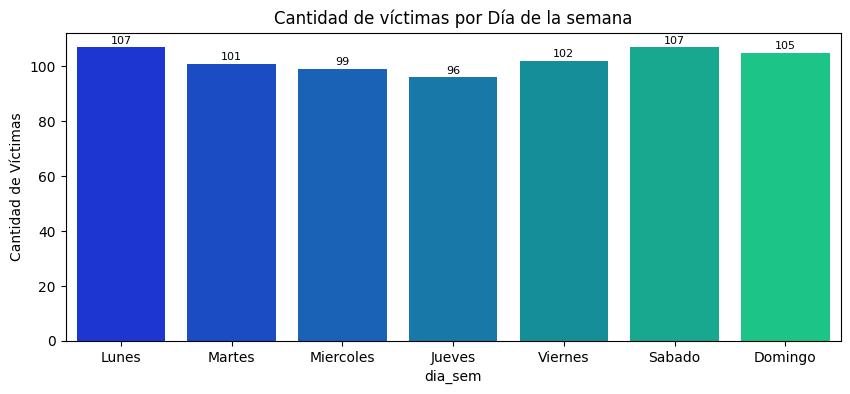

In [71]:
# Define el orden de los días de la semana
orden_dias_semana = ["Lunes", "Martes", "Miercoles", "Jueves", "Viernes", "Sabado", "Domingo"]

# Crea una columna 'orden_sem' en el DataFrame para representar el orden numérico de los días de la semana
data2['orden_sem'] = data2['dia_sem'].apply(lambda x: orden_dias_semana.index(x))

# Ordena el DataFrame según el orden numérico de los días de la semana
data2 = data2.sort_values(by='orden_sem')



# Se grafica
plt.figure(figsize=(10,4))

ax = sns.barplot(x='dia_sem', y='n_victimas', data=data2, palette="winter")
ax.set_title('Cantidad de víctimas por Día de la semana')
ax.set_xlabel('dia_sem') ; ax.set_ylabel('Cantidad de Víctimas')

# Agregar etiquetas de número de víctimas en cada barra
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                textcoords='offset points')

# Se muestra el gráfico cambiar a semestre ? 
plt.show()

In [74]:
# Se agrupa por la cantidad de víctimas por fecha_formato
data = homicidios_lm.groupby(['fecha_hora'])['n_victimas'].sum().reset_index()
#data["fecha_formato"]=data["fecha_formato"].astype("Int64")
#Creo una columna nueva `Día semana` que contenga el nombre del día de la semana
data['dia_sem'] = data['fecha_hora'].dt.strftime('%A')
data['hora'] = data['fecha_hora'].dt.hour

#Creo un diccionario para modificar a español los nombres de los dás de la semana y lo aplico a la columna nueva
dic={  'Friday':'Viernes',
       'Saturday': 'Sabado',
       'Sunday': 'Domingo',  
       'Thursday': 'Jueves',
        'Monday': 'Lunes',
        'Wednesday': 'Miercoles',
       'Tuesday': 'Martes'}
data['dia_sem'] =data['dia_sem'].replace(dic)
# Eliminar columnas innecesarias
columns_to_drop = ['fecha_hora']
data = data.drop(columns=columns_to_drop)
data2 = data.groupby(['dia_sem','hora'])['n_victimas'].sum().reset_index()


In [76]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162 entries, 0 to 161
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   dia_sem     162 non-null    object
 1   hora        162 non-null    int32 
 2   n_victimas  162 non-null    int64 
dtypes: int32(1), int64(1), object(1)
memory usage: 3.3+ KB


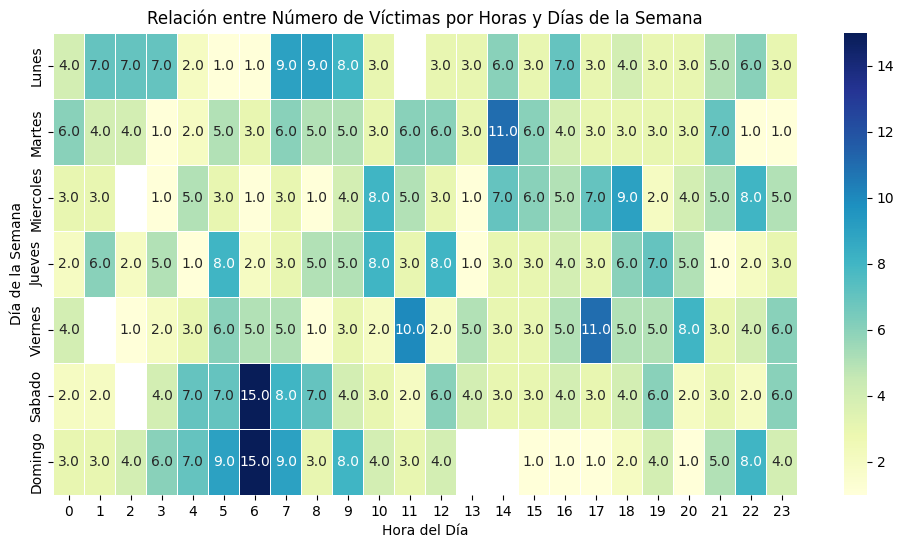

In [78]:
# Define el orden de los días de la semana
orden_dias_semana = ["Lunes", "Martes", "Miercoles", "Jueves", "Viernes", "Sabado", "Domingo"]

# Crea una columna 'orden_sem' en el DataFrame para representar el orden numérico de los días de la semana
data2['orden_sem'] = data2['dia_sem'].apply(lambda x: orden_dias_semana.index(x))

# Ordena el DataFrame según el orden numérico de los días de la semana
data2 = data2.sort_values(by='orden_sem')

# Crear una tabla pivot para los datos
pivot_data = data2.pivot_table(index= 'dia_sem', columns='hora', values='n_victimas', aggfunc='sum')
pivot_data = pivot_data.reindex(orden_dias_semana)

# Crear un mapa de calor (heatmap)
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_data, cmap='YlGnBu', annot=True, fmt='.1f', linewidths=0.5)

# Configurar etiquetas y título
plt.xlabel('Hora del Día')
plt.ylabel('Día de la Semana')
plt.title('Relación entre Número de Víctimas por Horas y Días de la Semana')

# Mostrar el gráfico
plt.show()
